## Predicting Default rate through ensemble learning 
In this script, we attempt to predict the loan default probability based on the loan info and customer's personal info.
What we did. We created a logistic regression, a decision tree classifier, a random forest model, a gradient boosting model, and a xgboost model, and performed stacking, an ensemble learning method that predicts the final y-value by the y-hats producted by all the models. 
Key words:
1. Hyperparameter tuning
2. Missing data imputation
3. Stacking
4. Machine learning
5. Binary classification



In [442]:

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import figure

import statsmodels.api as sm
from scipy.stats import norm
from scipy.stats import t

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [443]:
df = pd.read_csv("logistic_regression.txt")

# Data investigation:



checking missing values

In [446]:
def missing_df(data):
    total_missing_df = data.isna().sum().sort_values(ascending = False)
    percentage_missing_df = ((data.isna().sum()/len(data)*100)).sort_values(ascending = False)
    missingDF = pd.concat([total_missing_df, percentage_missing_df],axis = 1, keys=['Total', 'Percent'])
    return missingDF


missing_data = missing_df(df)
missing_data[missing_data["Total"]>0]


,Total,Percent
mort_acc,37795,9.543469
emp_title,22927,5.789208
emp_length,18301,4.621115
title,1755,0.443148
pub_rec_bankruptcies,535,0.135091
revol_util,276,0.069692


In [447]:
(df.isna().sum() / df.shape[0] ) * 100

loan_amnt               0.000000
term                    0.000000
int_rate                0.000000
installment             0.000000
grade                   0.000000
sub_grade               0.000000
emp_title               5.789208
emp_length              4.621115
home_ownership          0.000000
annual_inc              0.000000
verification_status     0.000000
issue_d                 0.000000
loan_status             0.000000
purpose                 0.000000
title                   0.443148
dti                     0.000000
earliest_cr_line        0.000000
open_acc                0.000000
pub_rec                 0.000000
revol_bal               0.000000
revol_util              0.069692
total_acc               0.000000
initial_list_status     0.000000
application_type        0.000000
mort_acc                9.543469
pub_rec_bankruptcies    0.135091
address                 0.000000
dtype: float64

### Descriptive Statistics :

In [448]:
df.describe().round(1)

,loan_amnt,int_rate,installment,annual_inc,dti,open_acc,pub_rec,revol_bal,revol_util,total_acc,mort_acc,pub_rec_bankruptcies
count,396030.0,396030.0,396030.0,396030.0,396030.0,396030.0,396030.0,396030.0,395754.0,396030.0,358235.0,395495.0
mean,14113.9,13.6,431.8,74203.2,17.4,11.3,0.2,15844.5,53.8,25.4,1.8,0.1
std,8357.4,4.5,250.7,61637.6,18.0,5.1,0.5,20591.8,24.5,11.9,2.1,0.4
min,500.0,5.3,16.1,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
25%,8000.0,10.5,250.3,45000.0,11.3,8.0,0.0,6025.0,35.8,17.0,0.0,0.0
50%,12000.0,13.3,375.4,64000.0,16.9,10.0,0.0,11181.0,54.8,24.0,1.0,0.0
75%,20000.0,16.5,567.3,90000.0,23.0,14.0,0.0,19620.0,72.9,32.0,3.0,0.0
max,40000.0,31.0,1533.8,8706582.0,9999.0,90.0,86.0,1743266.0,892.3,151.0,34.0,8.0


- #### Loan Amount, Installments, Annual Income , revol_bal : all these columns have large differnece in mean and median . That means outliers are present in the data. 

In [449]:
df.nunique()

loan_amnt                 1397
term                         2
int_rate                   566
installment              55706
grade                        7
sub_grade                   35
emp_title               173105
emp_length                  11
home_ownership               6
annual_inc               27197
verification_status          3
issue_d                    115
loan_status                  2
purpose                     14
title                    48817
dti                       4262
earliest_cr_line           684
open_acc                    61
pub_rec                     20
revol_bal                55622
revol_util                1226
total_acc                  118
initial_list_status          2
application_type             3
mort_acc                    33
pub_rec_bankruptcies         9
address                 393700
dtype: int64

In [450]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 396030 entries, 0 to 396029
Data columns (total 27 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   loan_amnt             396030 non-null  float64
 1   term                  396030 non-null  object 
 2   int_rate              396030 non-null  float64
 3   installment           396030 non-null  float64
 4   grade                 396030 non-null  object 
 5   sub_grade             396030 non-null  object 
 6   emp_title             373103 non-null  object 
 7   emp_length            377729 non-null  object 
 8   home_ownership        396030 non-null  object 
 9   annual_inc            396030 non-null  float64
 10  verification_status   396030 non-null  object 
 11  issue_d               396030 non-null  object 
 12  loan_status           396030 non-null  object 
 13  purpose               396030 non-null  object 
 14  title                 394275 non-null  object 
 15  

In [451]:
columns_type = df.dtypes
columns_type[columns_type=="object"]

term                   object
grade                  object
sub_grade              object
emp_title              object
emp_length             object
home_ownership         object
verification_status    object
issue_d                object
loan_status            object
purpose                object
title                  object
earliest_cr_line       object
initial_list_status    object
application_type       object
address                object
dtype: object

In [452]:
df.describe(include="object")

,term,grade,sub_grade,emp_title,emp_length,home_ownership,verification_status,issue_d,loan_status,purpose,title,earliest_cr_line,initial_list_status,application_type,address
count,396030,396030,396030,373103,377729,396030,396030,396030,396030,396030,394275,396030,396030,396030,396030
unique,2,7,35,173105,11,6,3,115,2,14,48817,684,2,3,393700
top,36 months,B,B3,Teacher,10+ years,MORTGAGE,Verified,Oct-2014,Fully Paid,debt_consolidation,Debt consolidation,Oct-2000,f,INDIVIDUAL,USCGC Smith\nFPO AE 70466
freq,302005,116018,26655,4389,126041,198348,139563,14846,318357,234507,152472,3017,238066,395319,8


In [453]:
len(columns_type[columns_type=="object"])

15

- #### 15 Non-numerical (categorical/date time) features present in the dataset. 

In [454]:
df["loan_status"].value_counts(normalize=True)*100

Fully Paid     80.387092
Charged Off    19.612908
Name: loan_status, dtype: float64

- #### As we can see, there is an imbalance in the data. 
- 80% belongs to the class 0 : which is loan fully paid. 
- 20% belongs to the class 1 : which were charged off. 

## checking for very high colinearity using heatmap - correlation matrix : 

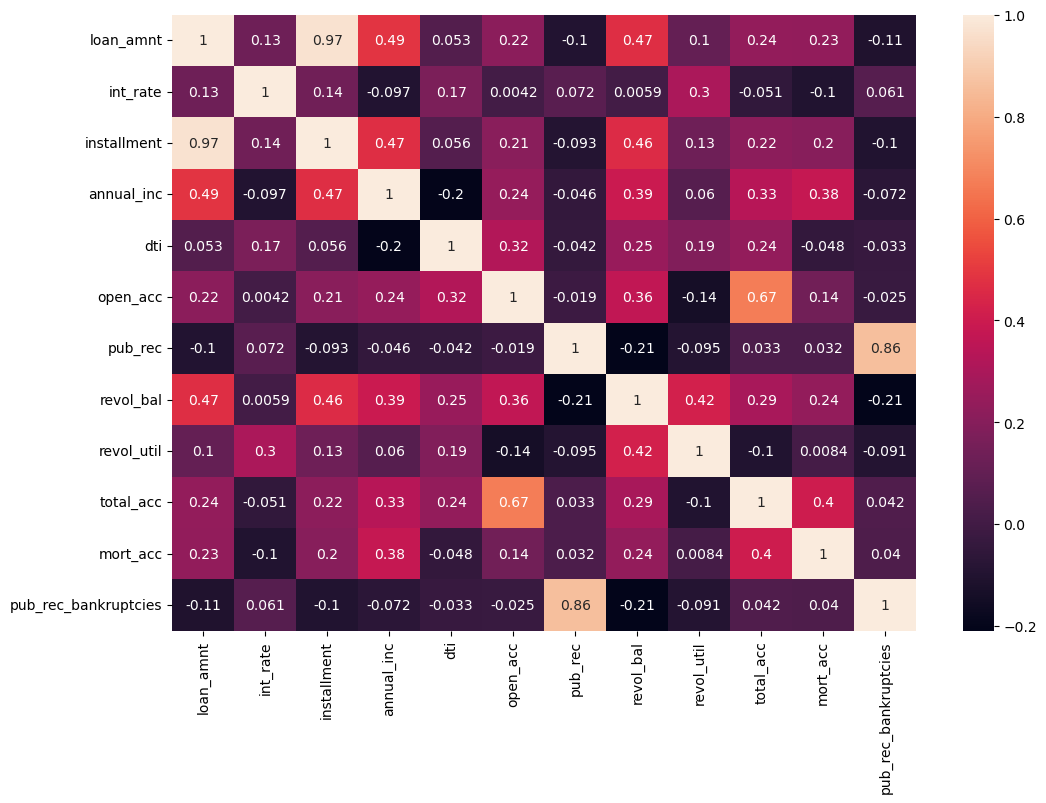

In [455]:
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(method='spearman'), annot=True)
plt.show()

#### removing intallment column , since it has very high correlation with loan_amount.
#### basically both represent same thing

In [456]:
df.drop("installment",axis = 1 , inplace=True)

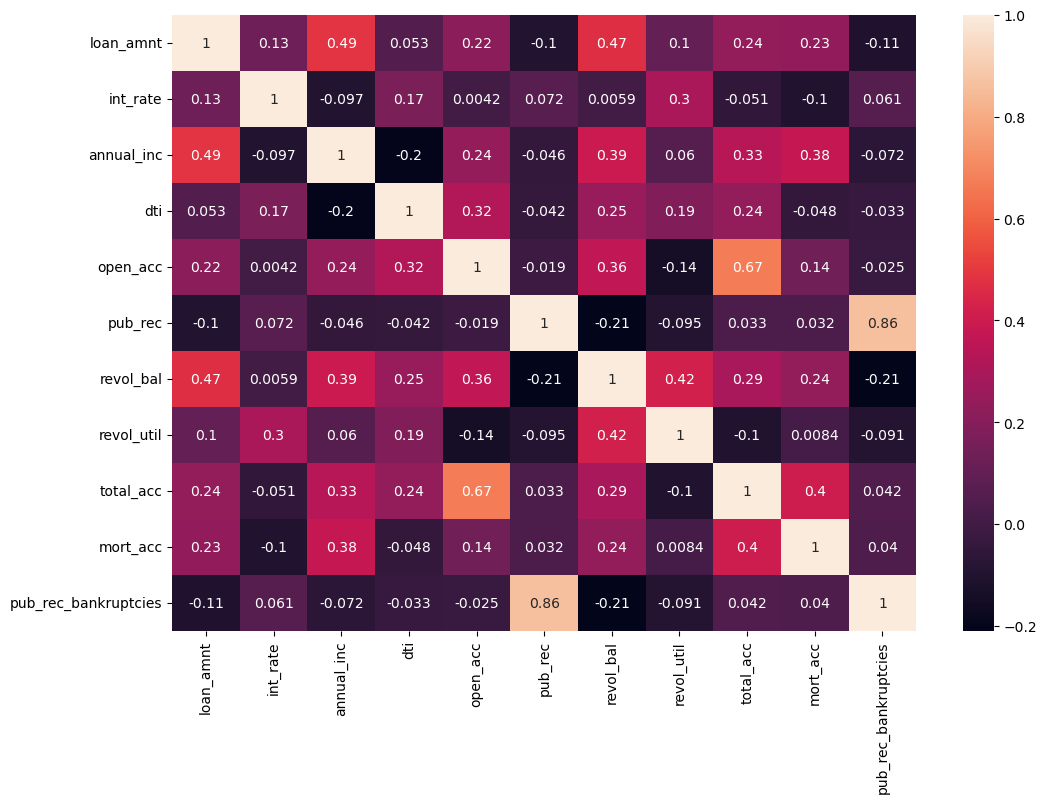

In [457]:
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(method='spearman'), annot=True)
plt.show()

# Data Exploration 



- #### The listed amount of the loan applied for by the borrower. If at some point in time, the credit department reduces the loan amount, then it will be reflected in this value.



In [458]:
df.groupby(by = "loan_status")["loan_amnt"].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,77673.0,15126.300967,8505.090557,1000.0,8525.0,14000.0,20000.0,40000.0
Fully Paid,318357.0,13866.878771,8302.319699,500.0,7500.0,12000.0,19225.0,40000.0


<AxesSubplot:xlabel='loan_status', ylabel='loan_amnt'>

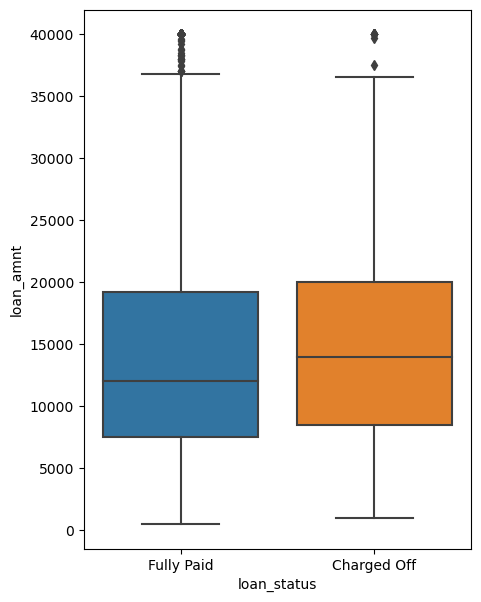

In [459]:
plt.figure(figsize=(5,7))
sns.boxplot(y=df["loan_amnt"],
            x=df["loan_status"])

### home_ownership

In [460]:
df["home_ownership"].value_counts()

MORTGAGE    198348
RENT        159790
OWN          37746
OTHER          112
NONE            31
ANY              3
Name: home_ownership, dtype: int64

<AxesSubplot:xlabel='home_ownership'>

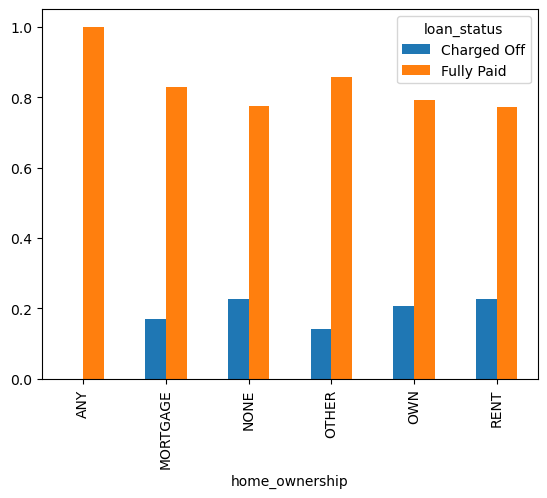

In [461]:
pd.crosstab(columns = df["loan_status"],
           index=df["home_ownership"], 
           normalize="index").plot(kind="bar")

In [462]:
df.groupby(by = "loan_status")["home_ownership"].describe()

,count,unique,top,freq
loan_status,,,,
Charged Off,77673,5,RENT,36212
Fully Paid,318357,6,MORTGAGE,164716


#### majority of people have home ownership as Mortgage and Rented.
#### Borrows having rented home, have higher conditional probability of loanStatus as Charged off. 


In [463]:
# df.loc[(df.home_ownership == "ANY") | (df.home_ownership == "NONE")]["home_ownership"] = "OTHER"

In [464]:
df["home_ownership"].unique()

array(['RENT', 'MORTGAGE', 'OWN', 'OTHER', 'NONE', 'ANY'], dtype=object)

In [465]:
df["home_ownership"].replace({"ANY":"OTHER",
                             "NONE":"OTHER"},
                            inplace=True)

<AxesSubplot:xlabel='home_ownership'>

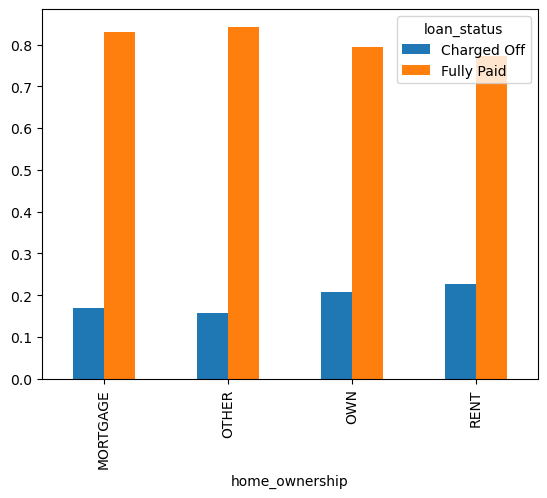

In [466]:
pd.crosstab(columns = df["loan_status"],
           index=df["home_ownership"], 
           normalize="index").plot(kind="bar")

###  Interest Rate : 

In [467]:
df.groupby(by = "loan_status")["int_rate"].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,77673.0,15.882587,4.388135,5.32,12.99,15.61,18.64,30.99
Fully Paid,318357.0,13.092105,4.319105,5.32,9.91,12.99,15.61,30.99


<AxesSubplot:xlabel='int_rate'>

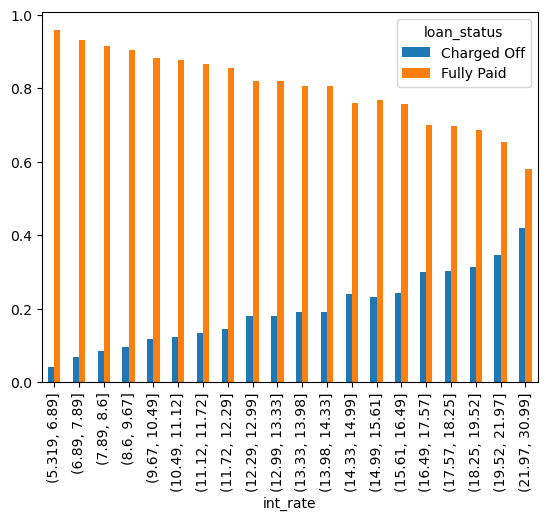

In [468]:
pd.crosstab(columns = df["loan_status"],
           index=pd.qcut(df["int_rate"],20), 
           normalize="index").plot(kind="bar")


In [469]:
# Higher the interest , probability of defailter is decreases. 

#### Some issue with "title" having duplicat values : needs to be fixed 

In [470]:
df["title"].value_counts()[:20]

Debt consolidation           152472
Credit card refinancing       51487
Home improvement              15264
Other                         12930
Debt Consolidation            11608
Major purchase                 4769
Consolidation                  3852
debt consolidation             3547
Business                       2949
Debt Consolidation Loan        2864
Medical expenses               2742
Car financing                  2139
Credit Card Consolidation      1775
Vacation                       1717
Moving and relocation          1689
consolidation                  1595
Personal Loan                  1591
Consolidation Loan             1299
Home Improvement               1268
Home buying                    1183
Name: title, dtype: int64

In [471]:
df["title"] = df["title"].str.lower()

In [472]:
df["title"].value_counts()[:20]

debt consolidation           168108
credit card refinancing       51781
home improvement              17117
other                         12993
consolidation                  5583
major purchase                 4998
debt consolidation loan        3513
business                       3017
medical expenses               2820
credit card consolidation      2638
personal loan                  2460
car financing                  2160
credit card payoff             1904
consolidation loan             1887
vacation                       1866
credit card refinance          1832
moving and relocation          1693
consolidate                    1528
personal                       1465
home buying                    1196
Name: title, dtype: int64

#### Changing data types of Date time columns :" 

In [473]:
df['issue_d'] = pd.to_datetime(df['issue_d'])
df['earliest_cr_line'] = pd.to_datetime(df['earliest_cr_line'])

### Loan Grades : 

In [474]:
df["grade"].unique()

array(['B', 'A', 'C', 'E', 'D', 'F', 'G'], dtype=object)

In [475]:
df["sub_grade"].unique()

array(['B4', 'B5', 'B3', 'A2', 'C5', 'C3', 'A1', 'B2', 'C1', 'A5', 'E4',
       'A4', 'A3', 'D1', 'C2', 'B1', 'D3', 'D5', 'D2', 'E1', 'E2', 'E5',
       'F4', 'E3', 'D4', 'G1', 'F5', 'G2', 'C4', 'F1', 'F3', 'G5', 'G4',
       'F2', 'G3'], dtype=object)

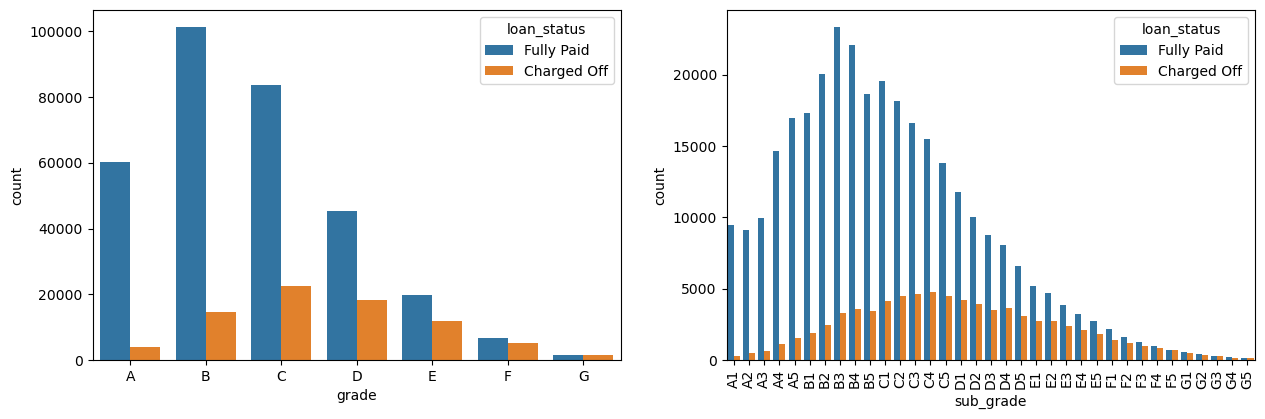

In [476]:
plt.figure(figsize=(15, 10))
plt.subplot(2, 2, 1)
grade = sorted(df.grade.unique().tolist())
sns.countplot(x='grade', data=df, hue='loan_status', order=grade)
plt.subplot(2, 2, 2)
sub_grade = sorted(df.sub_grade.unique().tolist())
g = sns.countplot(x='sub_grade', data=df, hue='loan_status', order=sub_grade)
g.set_xticklabels(g.get_xticklabels(), rotation=90);


## Probability plots for other categorical features : 

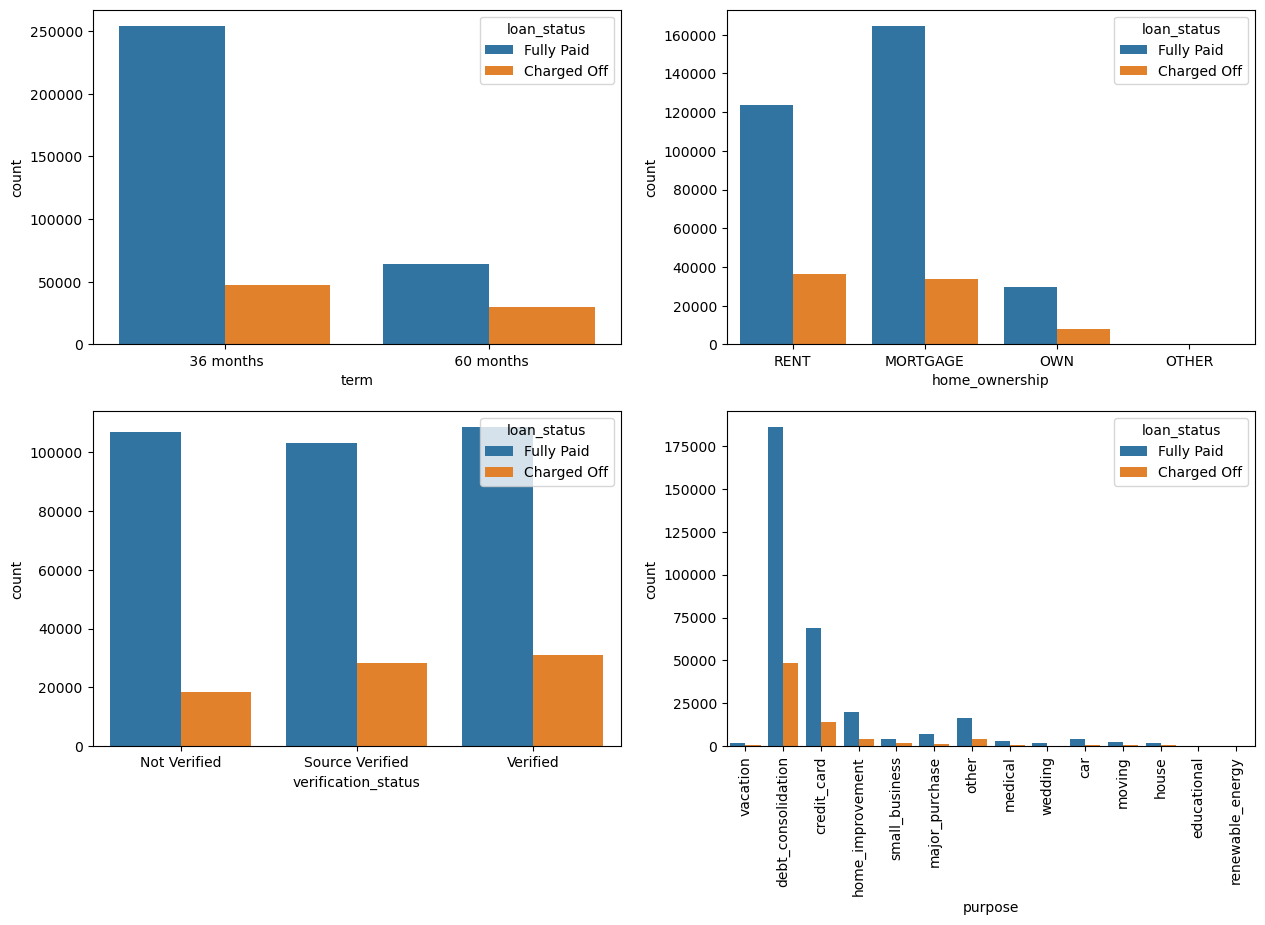

In [477]:
plt.figure(figsize=(15, 20))
plt.subplot(4, 2, 1)
sns.countplot(x='term', data=df, hue='loan_status')
plt.subplot(4, 2, 2)
sns.countplot(x='home_ownership', data=df, hue='loan_status')
plt.subplot(4, 2, 3)
sns.countplot(x='verification_status', data=df, hue='loan_status')
plt.subplot(4, 2, 4)
g = sns.countplot(x='purpose', data=df, hue='loan_status')
g.set_xticklabels(g.get_xticklabels(), rotation=90);

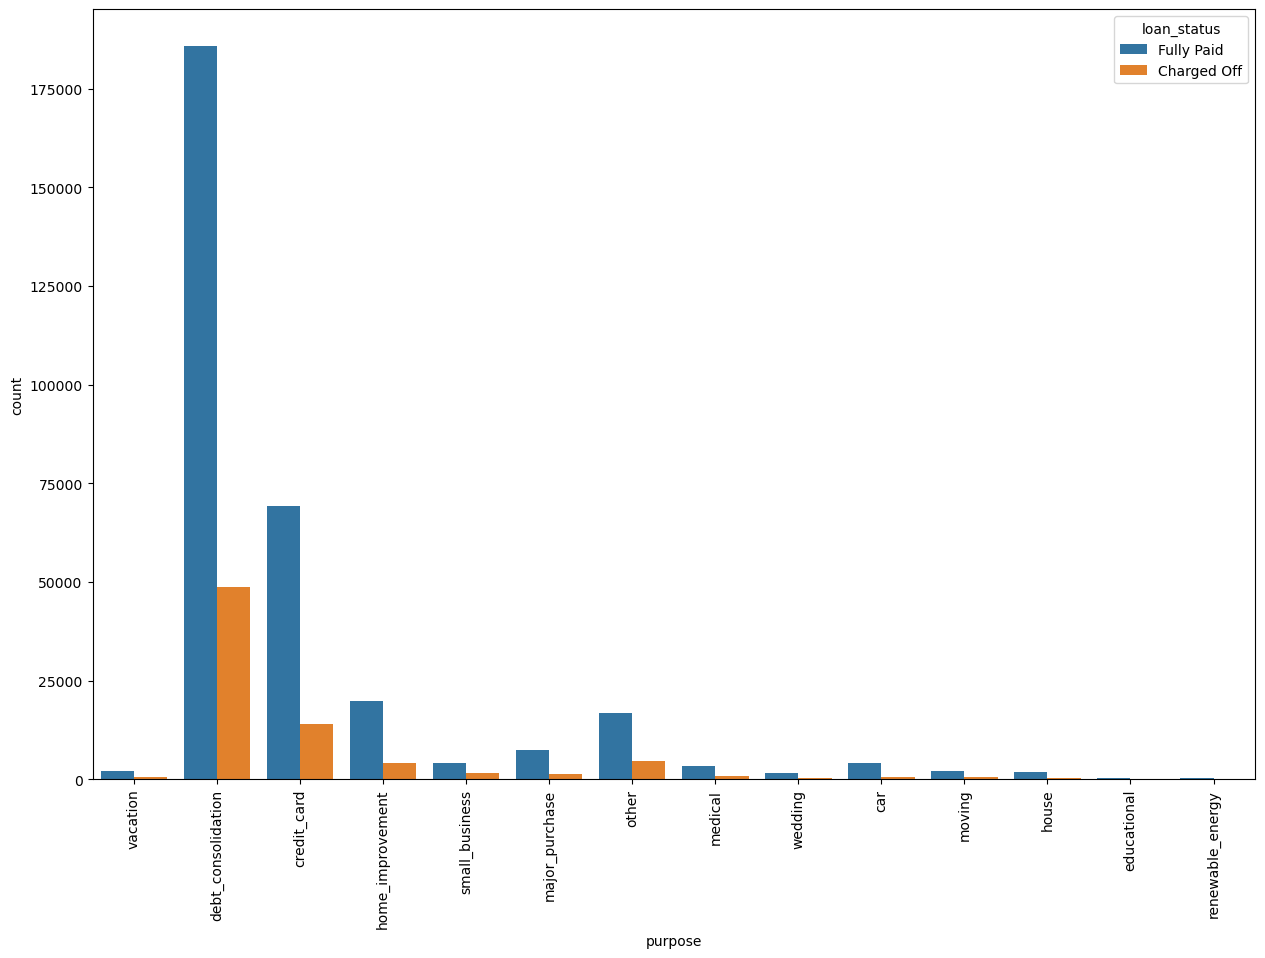

In [478]:
plt.figure(figsize=(15, 10))

sns.countplot(x='purpose', data=df, hue='loan_status')
plt.xticks(rotation = 90)
plt.show()

#### Loan taken for the porpose like dept_consolidation , credit card payments  , small business investments , have high probability of borrower defaults. 

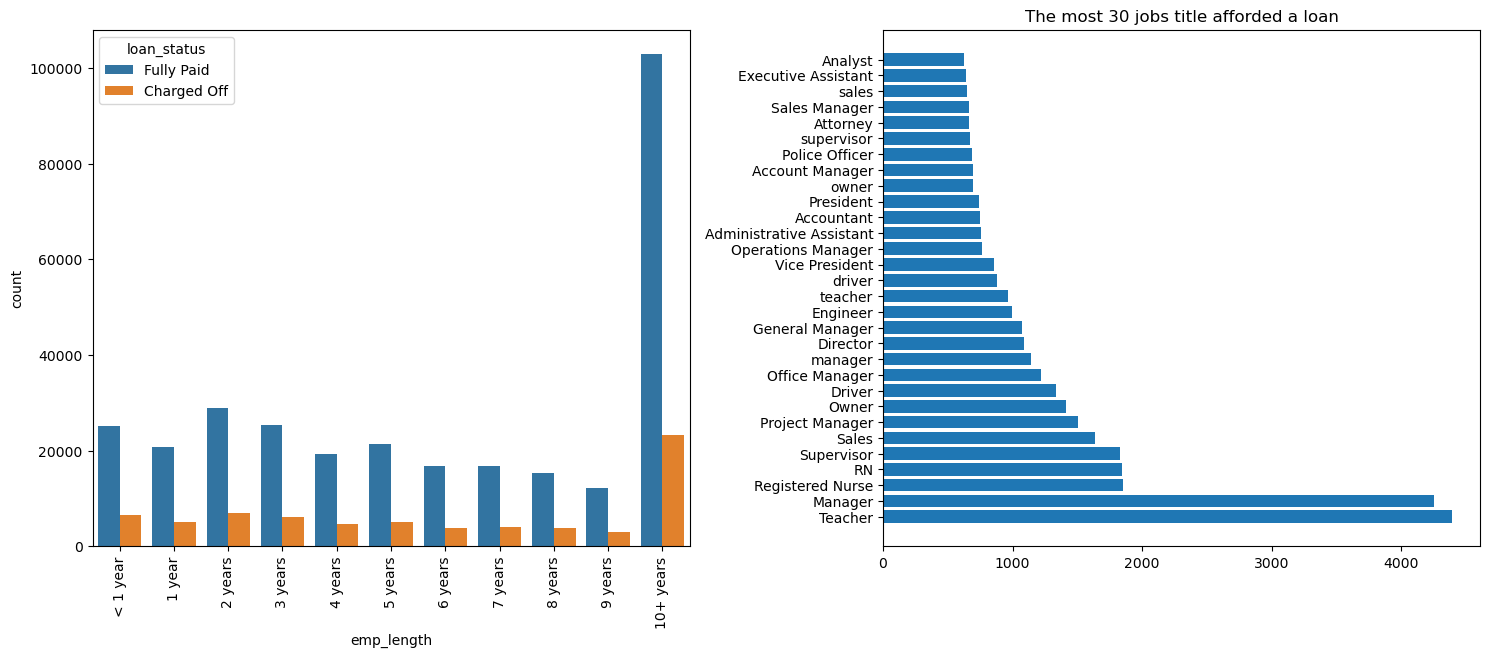

In [479]:
plt.figure(figsize=(15, 12))

plt.subplot(2, 2, 1)
order = ['< 1 year', '1 year', '2 years', '3 years', '4 years', '5 years',
 '6 years', '7 years', '8 years', '9 years', '10+ years',]
g = sns.countplot(x='emp_length', data=df, hue='loan_status', order=order)
g.set_xticklabels(g.get_xticklabels(), rotation=90);


plt.subplot(2, 2, 2)
plt.barh(df.emp_title.value_counts()[:30].index,
         df.emp_title.value_counts()[:30])
plt.title("The most 30 jobs title afforded a loan")
plt.tight_layout()

<AxesSubplot:xlabel='emp_length'>

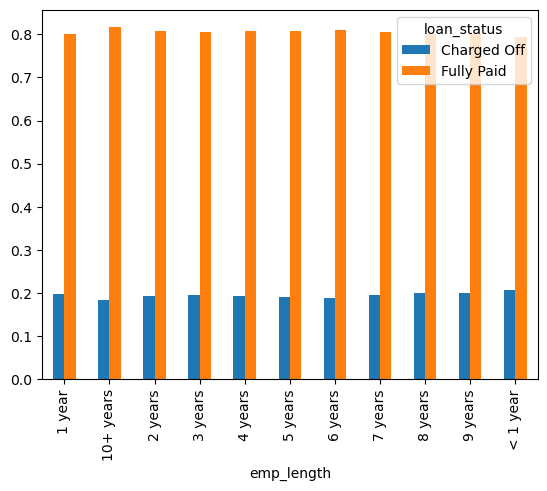

In [480]:

pd.crosstab(index = df["emp_length"],
            columns= df["loan_status"],normalize= "index").plot(kind = "bar")

In [481]:
# there doent seems to be much correlation between employement length 
# and loan_status.

### Annual Income : 



<AxesSubplot:xlabel='loan_status', ylabel='annual_inc'>

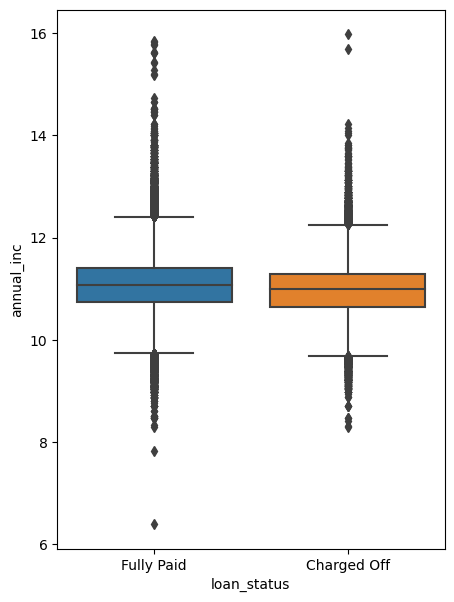

In [482]:
plt.figure(figsize=(5,7))
sns.boxplot(y=np.log(df[df["annual_inc"]>0]["annual_inc"]),
            x=df["loan_status"])

In [483]:
# no difference between annual income, for loan status categories 

<AxesSubplot:xlabel='pub_rec'>

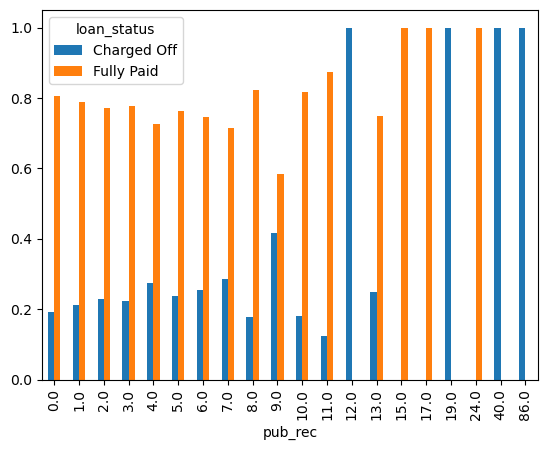

In [484]:
pd.crosstab(columns = df["loan_status"],
           index=(df["pub_rec"]), 
           normalize="index").plot(kind="bar")


In [485]:
# borrowers who have more the public records in history , have higher chances of default. 


<AxesSubplot:xlabel='loan_status', ylabel='revol_bal'>

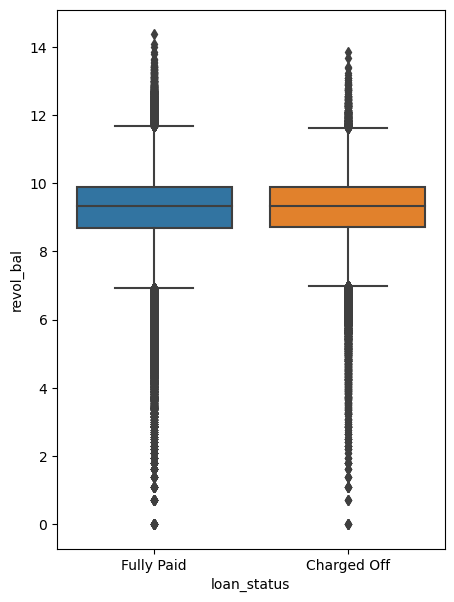

In [486]:
plt.figure(figsize=(5,7))
sns.boxplot(y= np.log(df["revol_bal"]),
            x=df["loan_status"])

In [487]:
# revolving balance is almost similar distribution for defaulters and non-defaulter.

<AxesSubplot:xlabel='total_acc'>

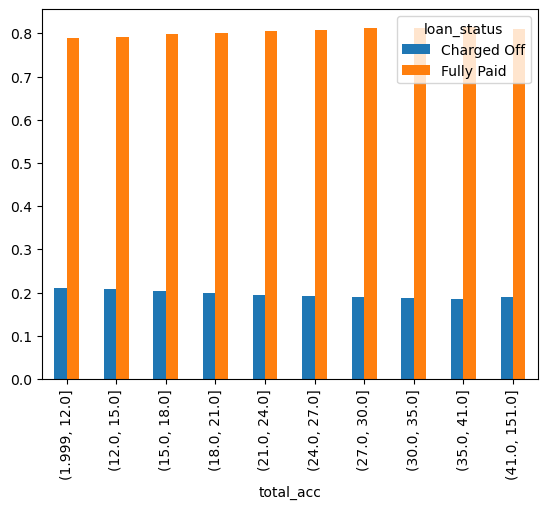

In [488]:
pd.crosstab(columns = df["loan_status"],
           index=pd.qcut(df["total_acc"],10), 
           normalize="index").plot(kind="bar")


In [489]:
# The total number of credit lines 
# currently in the borrower's credit file are same for defaulters and non defaulters.

### Application type : 

INDIVIDUAL    395319
JOINT            425
DIRECT_PAY       286
Name: application_type, dtype: int64


<AxesSubplot:xlabel='application_type'>

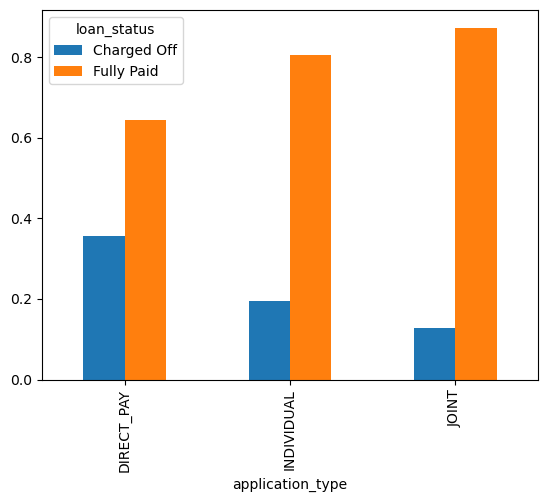

In [490]:
print(df["application_type"].value_counts(dropna=False))

pd.crosstab(index = df["application_type"],
            columns= df["loan_status"],normalize= "index").plot(kind = "bar")

## Feature Engineering  : 



In [491]:
def pub_rec(number):
    if number == 0.0:
        return 0
    else:
        return 1

def mort_acc(number):
    if number == 0.0:
        return 0
    elif number >= 1.0:
        return 1
    else:
        return number

def pub_rec_bankruptcies(number):
    if number == 0.0:
        return 0
    elif number >= 1.0:
        return 1
    else:
        return number

In [492]:
df['pub_rec'] = df.pub_rec.apply(pub_rec)
df['mort_acc'] = df.mort_acc.apply(mort_acc)
df['pub_rec_bankruptcies'] = df.pub_rec_bankruptcies.apply(pub_rec_bankruptcies)

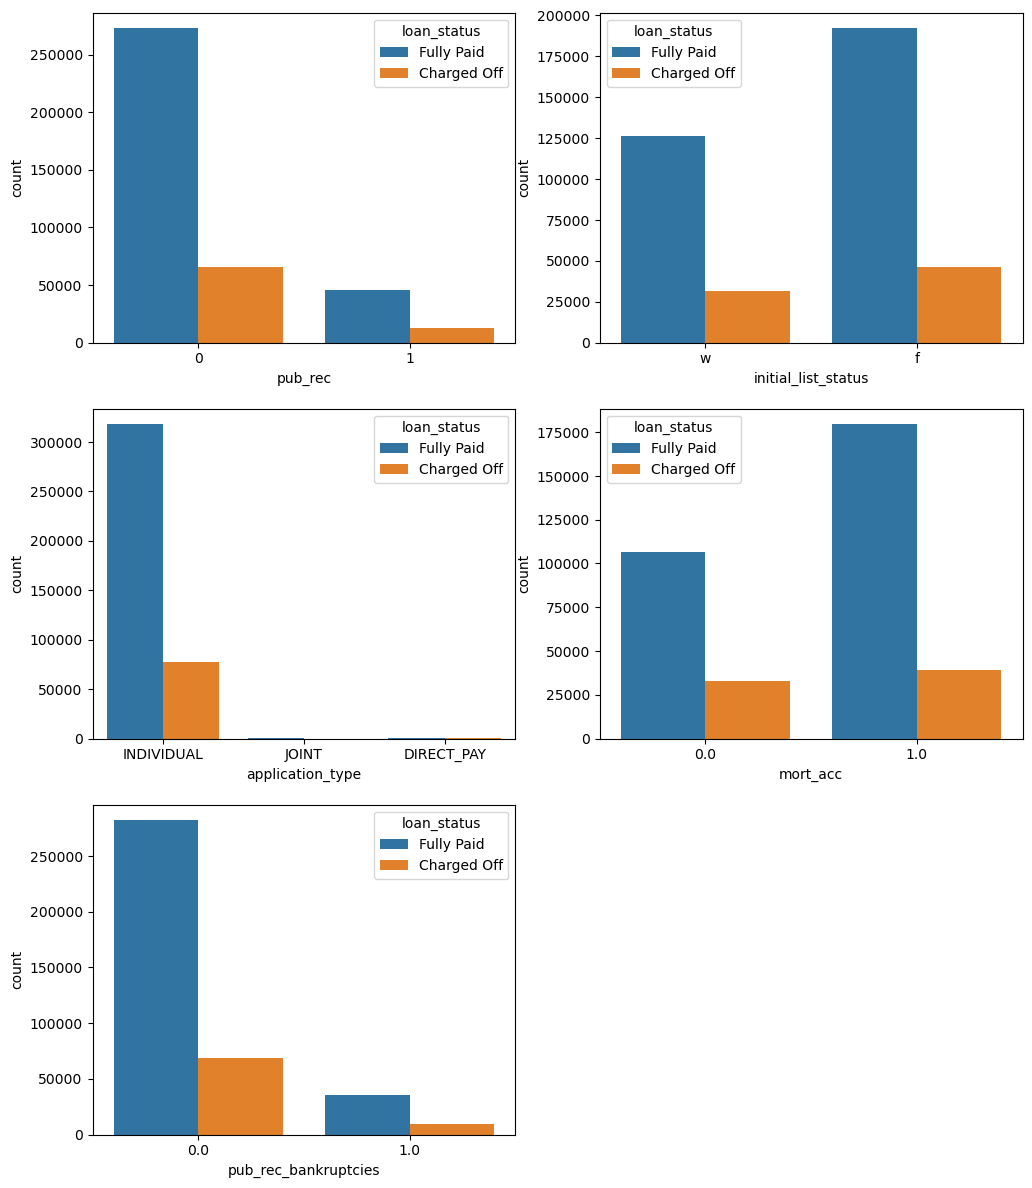

In [493]:
plt.figure(figsize=(12, 30))
plt.subplot(6, 2, 1)
sns.countplot(x='pub_rec', data=df, hue='loan_status')
plt.subplot(6, 2, 2)
sns.countplot(x='initial_list_status', data=df, hue='loan_status')
plt.subplot(6, 2, 3)
sns.countplot(x='application_type', data=df, hue='loan_status')
plt.subplot(6, 2, 4)
sns.countplot(x='mort_acc', data=df, hue='loan_status')
plt.subplot(6, 2, 5)
sns.countplot(x='pub_rec_bankruptcies', data=df, hue='loan_status')
plt.show()

## Converting target values : 
- ### if loanStatus is Fully Paid : 0
- ### if loanStatus is Charged Off : 1

In [494]:
df["loan_status"] = df["loan_status"].map({"Fully Paid":0,
                      "Charged Off":1})

### keeping an eye on missing values 

In [495]:
# (df.isna().sum()/df.shape[0]) *100

In [496]:
missing_data[missing_data["Percent"]>0]

,Total,Percent
mort_acc,37795,9.543469
emp_title,22927,5.789208
emp_length,18301,4.621115
title,1755,0.443148
pub_rec_bankruptcies,535,0.135091
revol_util,276,0.069692


## Mean Value Imputation : Target Encoding : 

In [497]:
# df.groupby("total_acc").mean()

In [498]:
total_acc_avg = df.groupby(by='total_acc').mean().mort_acc


In [499]:
# morc_acc_average_as_per_total_account

In [500]:
def fill_mort_acc(total_acc, mort_acc):
    if np.isnan(mort_acc):
        return total_acc_avg[total_acc].round()
    else:
        return mort_acc

In [501]:
df['mort_acc'] = df.apply(lambda x: fill_mort_acc(x['total_acc'], x['mort_acc']),axis = 1)

In [502]:
missing_data[missing_data["Percent"]>0]

,Total,Percent
mort_acc,37795,9.543469
emp_title,22927,5.789208
emp_length,18301,4.621115
title,1755,0.443148
pub_rec_bankruptcies,535,0.135091
revol_util,276,0.069692


In [503]:
(df.isna().sum()/df.shape[0]) *100

loan_amnt               0.000000
term                    0.000000
int_rate                0.000000
grade                   0.000000
sub_grade               0.000000
emp_title               5.789208
emp_length              4.621115
home_ownership          0.000000
annual_inc              0.000000
verification_status     0.000000
issue_d                 0.000000
loan_status             0.000000
purpose                 0.000000
title                   0.443148
dti                     0.000000
earliest_cr_line        0.000000
open_acc                0.000000
pub_rec                 0.000000
revol_bal               0.000000
revol_util              0.069692
total_acc               0.000000
initial_list_status     0.000000
application_type        0.000000
mort_acc                0.000000
pub_rec_bankruptcies    0.135091
address                 0.000000
dtype: float64

In [504]:
df["emp_title"].nunique()

173105

### Target Encoding for "pub_rec_bankruptcies":

#### Since there are 535 missing records of public record bankrupcies , we cannot remove them blindly or can impute with the most frequent. so , giving them some probability value of pub_rec_bankruptcy is a good idea. 
#### replacing those missing values with target encoding

In [505]:
df["pub_rec_bankruptcies"].value_counts(dropna=False)

0.0    350380
1.0     45115
NaN       535
Name: pub_rec_bankruptcies, dtype: int64

In [506]:
# df["pub_rec_bankruptcies"].fillna(0).value_counts(dropna=False)

In [507]:
from category_encoders import TargetEncoder
TE = TargetEncoder()

In [508]:
df["pub_rec_bankruptcies"] = df["pub_rec_bankruptcies"].fillna("Record_not_cound").astype("str")

In [509]:
df["pub_rec_bankruptcies"].value_counts(dropna=False)

0.0                 350380
1.0                  45115
Record_not_cound       535
Name: pub_rec_bankruptcies, dtype: int64

In [510]:
df["pub_rec_bankruptcies"] = TE.fit_transform(df["pub_rec_bankruptcies"],df["loan_status"])

In [511]:
df["pub_rec_bankruptcies"].value_counts(dropna=False)

0.194991    350380
0.205364     45115
0.162617       535
Name: pub_rec_bankruptcies, dtype: int64

In [512]:
(df.isna().sum()/df.shape[0]) *100

loan_amnt               0.000000
term                    0.000000
int_rate                0.000000
grade                   0.000000
sub_grade               0.000000
emp_title               5.789208
emp_length              4.621115
home_ownership          0.000000
annual_inc              0.000000
verification_status     0.000000
issue_d                 0.000000
loan_status             0.000000
purpose                 0.000000
title                   0.443148
dti                     0.000000
earliest_cr_line        0.000000
open_acc                0.000000
pub_rec                 0.000000
revol_bal               0.000000
revol_util              0.069692
total_acc               0.000000
initial_list_status     0.000000
application_type        0.000000
mort_acc                0.000000
pub_rec_bankruptcies    0.000000
address                 0.000000
dtype: float64

In [513]:
df.shape

(396030, 26)

## Dropping rest of the missing values : 

In [514]:
df.dropna(inplace=True)

In [515]:
(df.isna().sum()/df.shape[0]) *100

loan_amnt               0.0
term                    0.0
int_rate                0.0
grade                   0.0
sub_grade               0.0
emp_title               0.0
emp_length              0.0
home_ownership          0.0
annual_inc              0.0
verification_status     0.0
issue_d                 0.0
loan_status             0.0
purpose                 0.0
title                   0.0
dti                     0.0
earliest_cr_line        0.0
open_acc                0.0
pub_rec                 0.0
revol_bal               0.0
revol_util              0.0
total_acc               0.0
initial_list_status     0.0
application_type        0.0
mort_acc                0.0
pub_rec_bankruptcies    0.0
address                 0.0
dtype: float64

### Outlier Detection & Treatment  : 

In [516]:
numerical_data = df.select_dtypes(include='number')
numerical_data

,loan_amnt,int_rate,annual_inc,loan_status,dti,open_acc,pub_rec,revol_bal,revol_util,total_acc,mort_acc,pub_rec_bankruptcies
0,10000.0,11.44,117000.0,0,26.24,16.0,0,36369.0,41.8,25.0,0.0,0.194991
1,8000.0,11.99,65000.0,0,22.05,17.0,0,20131.0,53.3,27.0,1.0,0.194991
2,15600.0,10.49,43057.0,0,12.79,13.0,0,11987.0,92.2,26.0,0.0,0.194991
3,7200.0,6.49,54000.0,0,2.60,6.0,0,5472.0,21.5,13.0,0.0,0.194991
4,24375.0,17.27,55000.0,1,33.95,13.0,0,24584.0,69.8,43.0,1.0,0.194991
...,...,...,...,...,...,...,...,...,...,...,...,...
396025,10000.0,10.99,40000.0,0,15.63,6.0,0,1990.0,34.3,23.0,0.0,0.194991
396026,21000.0,12.29,110000.0,0,21.45,6.0,0,43263.0,95.7,8.0,1.0,0.194991
396027,5000.0,9.99,56500.0,0,17.56,15.0,0,32704.0,66.9,23.0,0.0,0.194991
396028,21000.0,15.31,64000.0,0,15.88,9.0,0,15704.0,53.8,20.0,1.0,0.194991


In [517]:
num_cols = numerical_data.columns
len(num_cols)

12

In [518]:
num_cols = ['loan_amnt', 'int_rate', 'annual_inc',  'dti', 'open_acc', 'revol_bal', 'revol_util', 'total_acc', 'mort_acc' ]

In [519]:
# def box_plot(col):
#     plt.figure(figsize=(8, 5))
#     sns.boxplot(x=df[col])
#     plt.title('Boxplot')
#     plt.show()

# for col in num_cols:
#     box_plot(col)


In [520]:
removed_ooutlier = df.copy()

In [521]:
for col in num_cols:
    mean = removed_ooutlier[col].mean()
    std = removed_ooutlier[col].std()
    upper_limit = mean+3*std
    lower_limit = mean-3*std
    removed_ooutlier = removed_ooutlier[(removed_ooutlier[col]<upper_limit) & (removed_ooutlier[col]>lower_limit)]
removed_ooutlier.shape

(355005, 26)

In [522]:
removed_ooutlier

,loan_amnt,term,int_rate,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,purpose,title,dti,earliest_cr_line,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,application_type,mort_acc,pub_rec_bankruptcies,address
0,10000.0,36 months,11.44,B,B4,Marketing,10+ years,RENT,117000.0,Not Verified,2015-01-01,0,vacation,vacation,26.24,1990-06-01,16.0,0,36369.0,41.8,25.0,w,INDIVIDUAL,0.0,0.194991,"0174 Michelle Gateway\nMendozaberg, OK 22690"
1,8000.0,36 months,11.99,B,B5,Credit analyst,4 years,MORTGAGE,65000.0,Not Verified,2015-01-01,0,debt_consolidation,debt consolidation,22.05,2004-07-01,17.0,0,20131.0,53.3,27.0,f,INDIVIDUAL,1.0,0.194991,"1076 Carney Fort Apt. 347\nLoganmouth, SD 05113"
2,15600.0,36 months,10.49,B,B3,Statistician,< 1 year,RENT,43057.0,Source Verified,2015-01-01,0,credit_card,credit card refinancing,12.79,2007-08-01,13.0,0,11987.0,92.2,26.0,f,INDIVIDUAL,0.0,0.194991,"87025 Mark Dale Apt. 269\nNew Sabrina, WV 05113"
3,7200.0,36 months,6.49,A,A2,Client Advocate,6 years,RENT,54000.0,Not Verified,2014-11-01,0,credit_card,credit card refinancing,2.60,2006-09-01,6.0,0,5472.0,21.5,13.0,f,INDIVIDUAL,0.0,0.194991,"823 Reid Ford\nDelacruzside, MA 00813"
4,24375.0,60 months,17.27,C,C5,Destiny Management Inc.,9 years,MORTGAGE,55000.0,Verified,2013-04-01,1,credit_card,credit card refinance,33.95,1999-03-01,13.0,0,24584.0,69.8,43.0,f,INDIVIDUAL,1.0,0.194991,"679 Luna Roads\nGreggshire, VA 11650"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
396025,10000.0,60 months,10.99,B,B4,licensed bankere,2 years,RENT,40000.0,Source Verified,2015-10-01,0,debt_consolidation,debt consolidation,15.63,2004-11-01,6.0,0,1990.0,34.3,23.0,w,INDIVIDUAL,0.0,0.194991,"12951 Williams Crossing\nJohnnyville, DC 30723"
396026,21000.0,36 months,12.29,C,C1,Agent,5 years,MORTGAGE,110000.0,Source Verified,2015-02-01,0,debt_consolidation,debt consolidation,21.45,2006-02-01,6.0,0,43263.0,95.7,8.0,f,INDIVIDUAL,1.0,0.194991,"0114 Fowler Field Suite 028\nRachelborough, LA..."
396027,5000.0,36 months,9.99,B,B1,City Carrier,10+ years,RENT,56500.0,Verified,2013-10-01,0,debt_consolidation,pay off credit cards,17.56,1997-03-01,15.0,0,32704.0,66.9,23.0,f,INDIVIDUAL,0.0,0.194991,"953 Matthew Points Suite 414\nReedfort, NY 70466"
396028,21000.0,60 months,15.31,C,C2,"Gracon Services, Inc",10+ years,MORTGAGE,64000.0,Verified,2012-08-01,0,debt_consolidation,loanforpayoff,15.88,1990-11-01,9.0,0,15704.0,53.8,20.0,f,INDIVIDUAL,1.0,0.194991,"7843 Blake Freeway Apt. 229\nNew Michael, FL 2..."


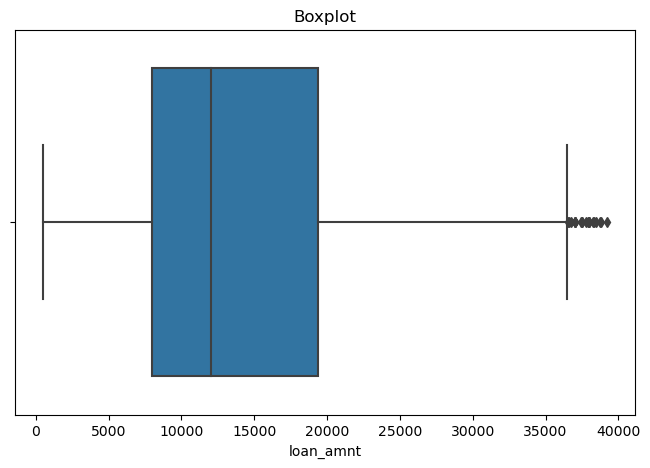

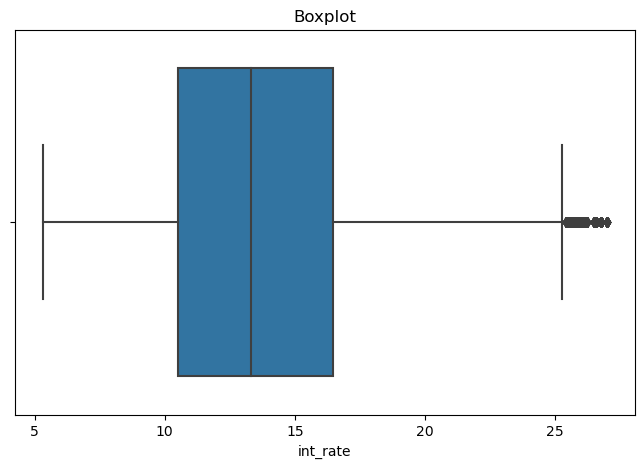

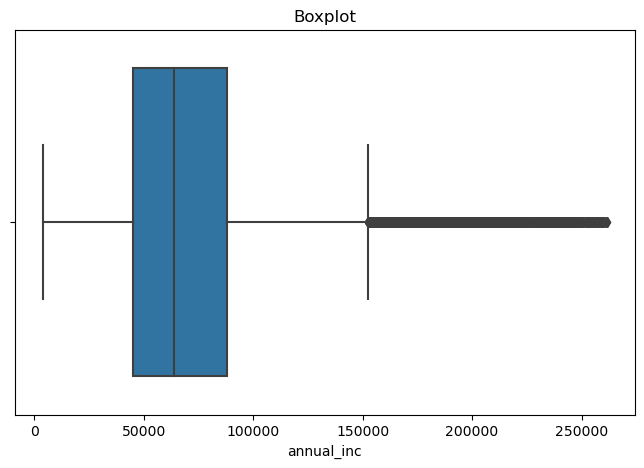

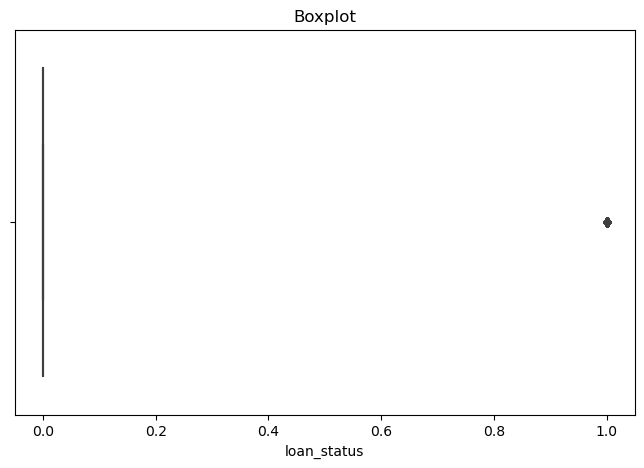

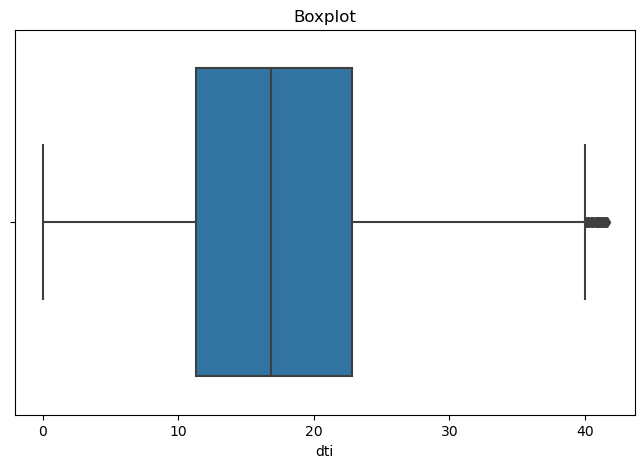

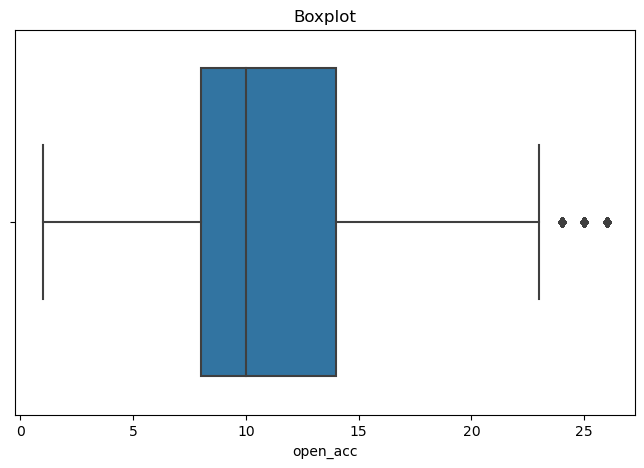

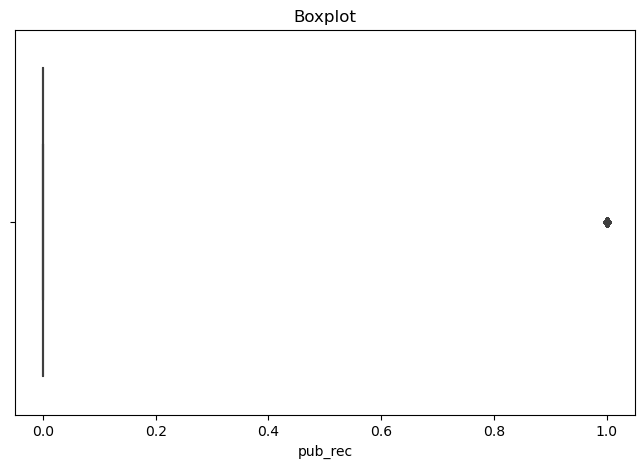

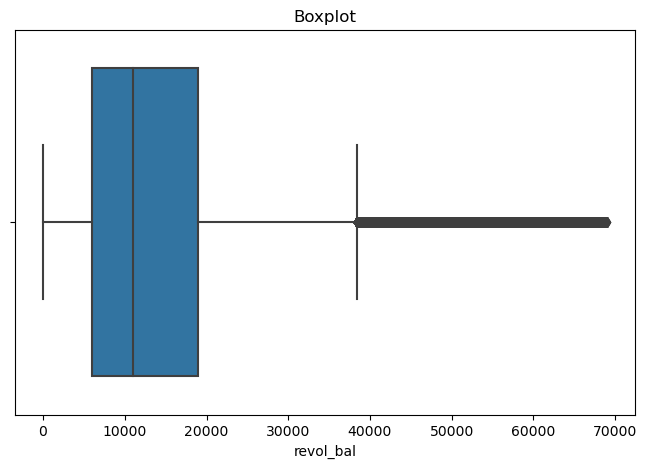

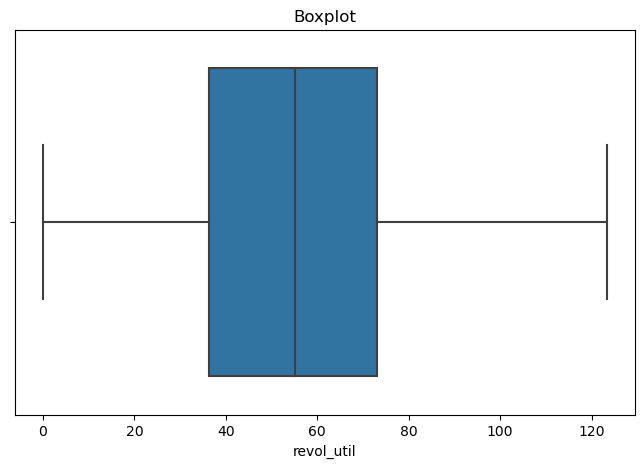

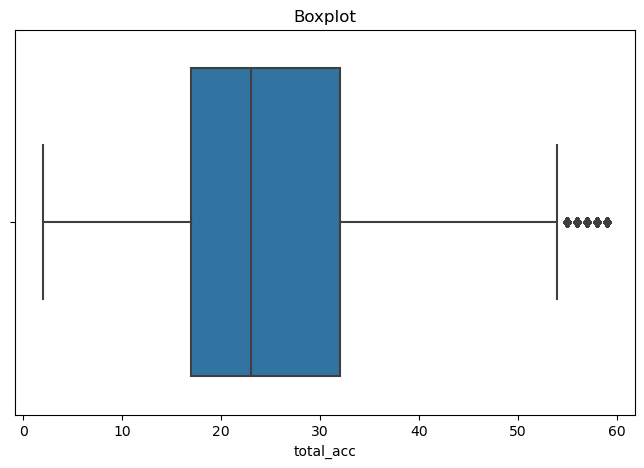

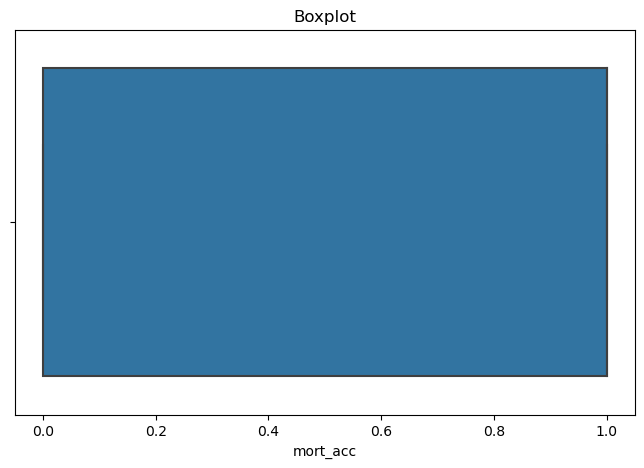

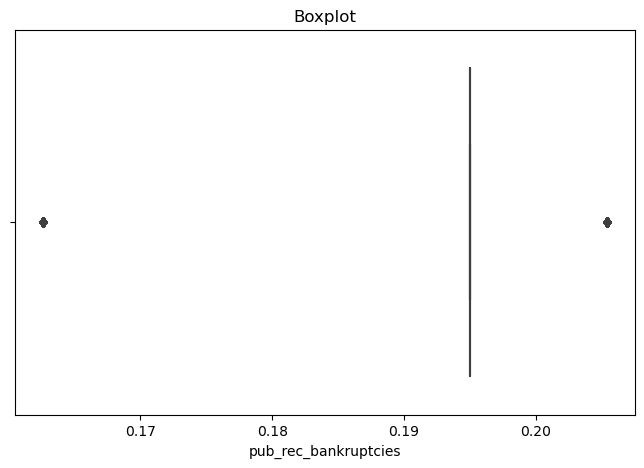

In [523]:
numerical_data = removed_ooutlier.select_dtypes(include='number')
numerical_data

num_cols = numerical_data.columns
len(num_cols)
def box_plot(col):
    plt.figure(figsize=(8, 5))
    sns.boxplot(x=removed_ooutlier[col])
    plt.title('Boxplot')
    plt.show()

for col in num_cols:
    box_plot(col)


In [524]:
# removed_ooutlier.pub_rec_bankruptcies.value_counts()

In [525]:
data = removed_ooutlier.copy()

## Data Preprocessing -

In [526]:

data['term'] = data.term.map({' 36 months': 36, ' 60 months': 60})


In [527]:

data['initial_list_status'] = data.initial_list_status.map({'w': 0, 'f': 1})


In [528]:
data.address.apply(lambda x: x[-5:])

0         22690
1         05113
2         05113
3         00813
4         11650
          ...  
396025    30723
396026    05113
396027    70466
396028    29597
396029    48052
Name: address, Length: 355005, dtype: object

In [529]:
data['zip_code'] = data.address.apply(lambda x: x[-5:])


In [530]:
data['zip_code'].value_counts(normalize=True)*100

70466    14.378671
30723    14.282616
22690    14.269095
48052    14.125153
00813    11.611949
29597    11.537302
05113    11.517021
93700     2.773764
11650     2.771229
86630     2.733201
Name: zip_code, dtype: float64

In [531]:
# dropping iirrelevant features : 
data.drop(columns=['issue_d',  'sub_grade','address', 'earliest_cr_line', 'emp_length'], axis=1, inplace=True)


In [532]:
data.drop("title",inplace=True,axis = 1)

In [533]:
data["emp_title"].nunique() # target_encoding

167202

In [534]:
data.columns

Index(['loan_amnt', 'term', 'int_rate', 'grade', 'emp_title', 'home_ownership', 'annual_inc', 'verification_status', 'loan_status', 'purpose', 'dti', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'initial_list_status', 'application_type', 'mort_acc', 'pub_rec_bankruptcies', 'zip_code'], dtype='object')

### Target encoding for employee title : 

In [535]:
from category_encoders import TargetEncoder
TE = TargetEncoder()

data["emp_title"] = TE.fit_transform(data["emp_title"],data["loan_status"])

In [536]:
# data["emp_title"] = TE.fit_transform(data["emp_title"],data["loan_status"])

In [537]:
data

,loan_amnt,term,int_rate,grade,emp_title,home_ownership,annual_inc,verification_status,loan_status,purpose,dti,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,application_type,mort_acc,pub_rec_bankruptcies,zip_code
0,10000.0,36,11.44,B,0.243798,RENT,117000.0,Not Verified,0,vacation,26.24,16.0,0,36369.0,41.8,25.0,0,INDIVIDUAL,0.0,0.194991,22690
1,8000.0,36,11.99,B,0.214179,MORTGAGE,65000.0,Not Verified,0,debt_consolidation,22.05,17.0,0,20131.0,53.3,27.0,1,INDIVIDUAL,1.0,0.194991,05113
2,15600.0,36,10.49,B,0.194452,RENT,43057.0,Source Verified,0,credit_card,12.79,13.0,0,11987.0,92.2,26.0,1,INDIVIDUAL,0.0,0.194991,05113
3,7200.0,36,6.49,A,0.167377,RENT,54000.0,Not Verified,0,credit_card,2.60,6.0,0,5472.0,21.5,13.0,1,INDIVIDUAL,0.0,0.194991,00813
4,24375.0,60,17.27,C,0.297485,MORTGAGE,55000.0,Verified,1,credit_card,33.95,13.0,0,24584.0,69.8,43.0,1,INDIVIDUAL,1.0,0.194991,11650
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
396025,10000.0,60,10.99,B,0.167377,RENT,40000.0,Source Verified,0,debt_consolidation,15.63,6.0,0,1990.0,34.3,23.0,0,INDIVIDUAL,0.0,0.194991,30723
396026,21000.0,36,12.29,C,0.208092,MORTGAGE,110000.0,Source Verified,0,debt_consolidation,21.45,6.0,0,43263.0,95.7,8.0,1,INDIVIDUAL,1.0,0.194991,05113
396027,5000.0,36,9.99,B,0.271928,RENT,56500.0,Verified,0,debt_consolidation,17.56,15.0,0,32704.0,66.9,23.0,1,INDIVIDUAL,0.0,0.194991,70466
396028,21000.0,60,15.31,C,0.167377,MORTGAGE,64000.0,Verified,0,debt_consolidation,15.88,9.0,0,15704.0,53.8,20.0,1,INDIVIDUAL,1.0,0.194991,29597


## One-hot-encoding for other categorical data : 

In [538]:
dummies = ["grade","home_ownership","verification_status","purpose","application_type"]

In [539]:
data = pd.get_dummies(data,columns=dummies,drop_first=True)

In [540]:
data.sample(5)

,loan_amnt,term,int_rate,emp_title,annual_inc,loan_status,dti,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,mort_acc,pub_rec_bankruptcies,zip_code,grade_B,grade_C,grade_D,grade_E,grade_F,grade_G,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,verification_status_Source Verified,verification_status_Verified,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,application_type_INDIVIDUAL,application_type_JOINT
42521,8000.0,36,14.33,0.167377,40000.0,0,26.82,5.0,0,6091.0,93.7,34.0,1,0.0,0.194991,29597,0,1,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0
200583,11000.0,60,17.76,0.280859,70000.0,0,11.83,9.0,1,5698.0,42.8,32.0,1,1.0,0.205364,30723,0,0,1,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0
343062,24000.0,60,13.99,0.077519,80000.0,0,12.06,13.0,0,16589.0,38.1,29.0,1,0.0,0.194991,48052,0,1,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0
320645,24000.0,36,14.65,0.167377,71000.0,0,30.96,12.0,0,24761.0,47.3,18.0,1,0.0,0.194991,05113,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0
257737,7425.0,36,13.05,0.167377,54600.0,0,25.49,7.0,0,4221.0,91.8,9.0,1,1.0,0.194991,22690,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0


# Feature Importance using Heatmap and correations : 

<AxesSubplot:>

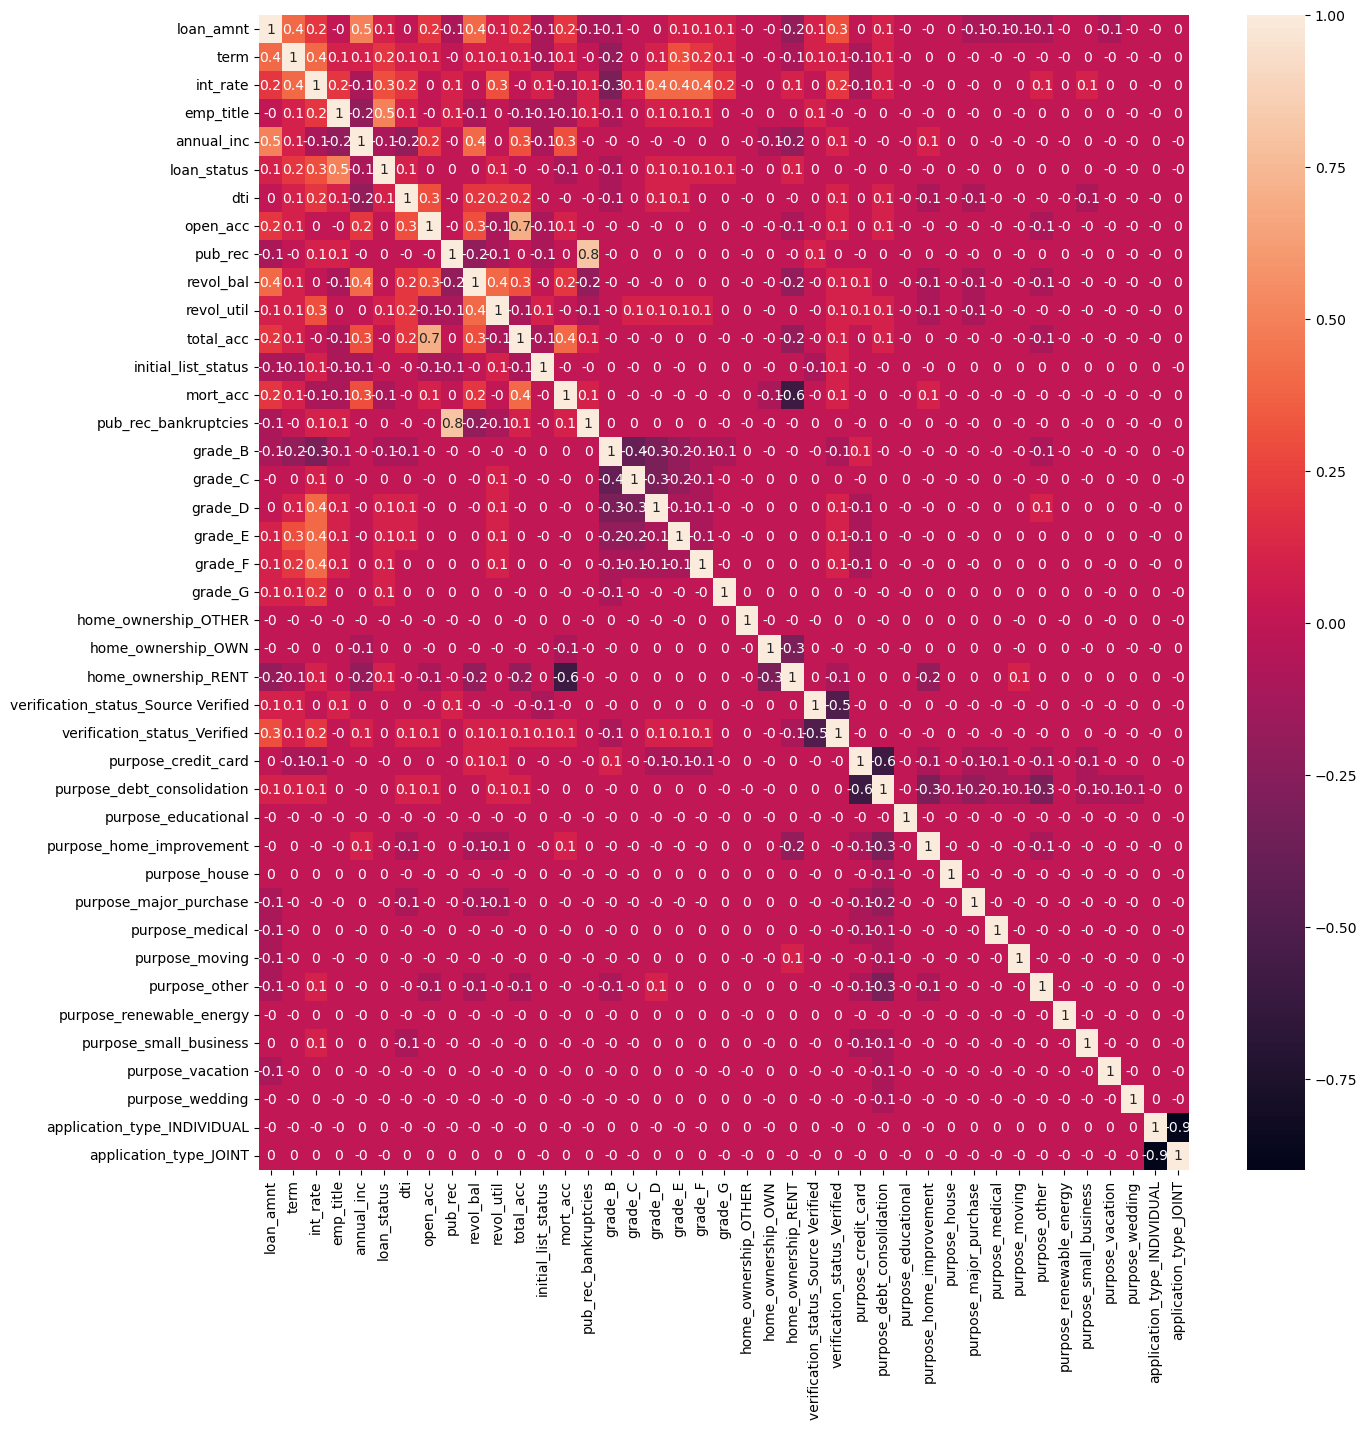

In [556]:
plt.figure(figsize=(15,15))
sns.heatmap(data.corr().round(1),annot=True,)

<AxesSubplot:>

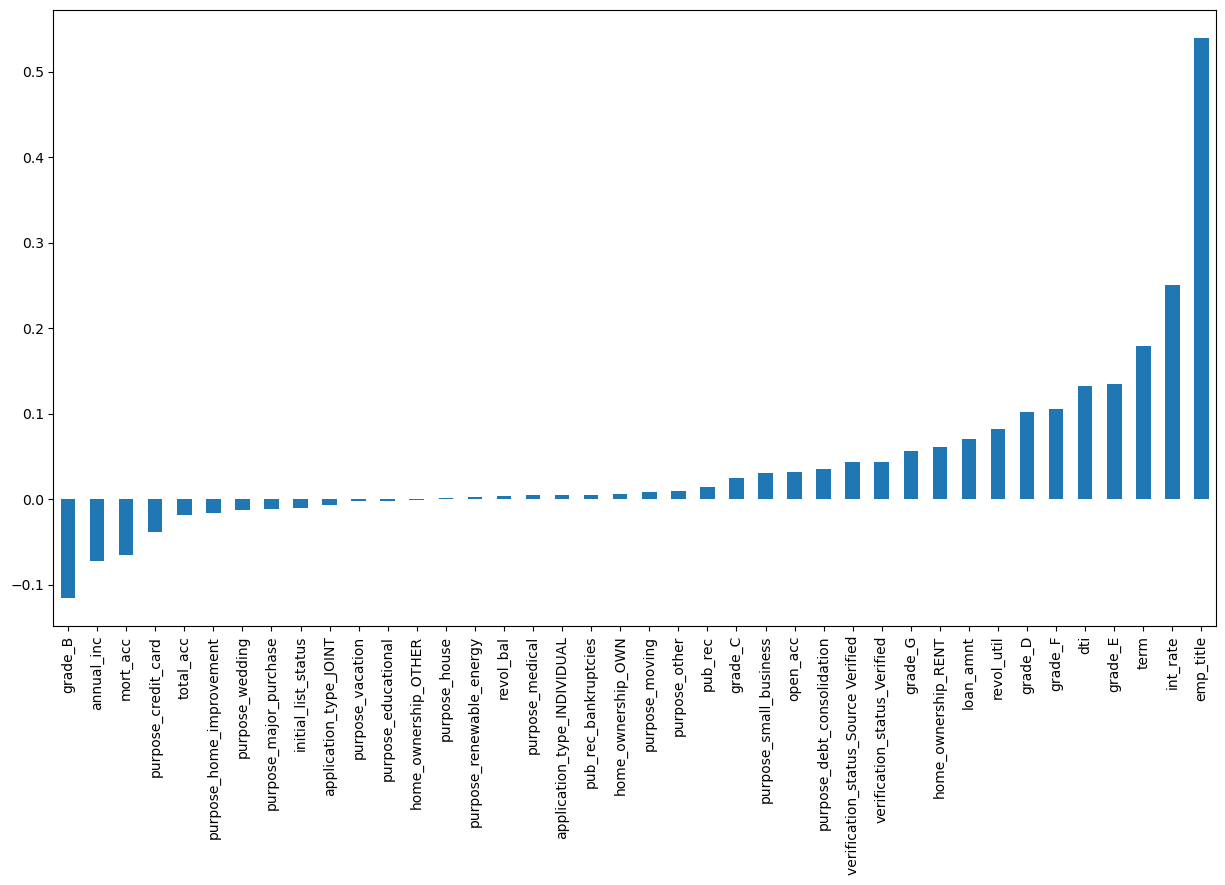

In [542]:
plt.figure(figsize=(15,8))

data.corr()["loan_status"].sort_values()[:-1].plot(kind = "bar")

# Data preparation for modeling: 

In [543]:
X = data.drop("loan_status",axis = 1)
y = data["loan_status"]

In [544]:
X.shape,y.shape

((355005, 41), (355005,))

### train-test-Split : 

In [545]:
from sklearn.model_selection import train_test_split

In [546]:
X_train , X_test,  y_train , y_test = train_test_split(X,y,
                                                      test_size=0.3,
                                                      random_state=42)

In [547]:
X_train.shape,X_test.shape

((248503, 41), (106502, 41))

In [548]:
X_train_non_scalled = X_train.copy()

In [549]:
X_test_non_scalled = X_test.copy()

## Scaling the data : 


In [550]:
from sklearn.preprocessing import StandardScaler

In [551]:
scaler = StandardScaler()
scaler.fit(X_train)

StandardScaler()

In [552]:
X_train = scaler.transform(X_train)

In [553]:
X_test = scaler.transform(X_test)

In [719]:
X_train['address']

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

## Logistic Regression : 

### Handling Data Imbalance : 

In [577]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=42)

X_smote, y_smote = sm.fit_resample(X_train, y_train.ravel())


In [578]:
## After over sampling : 
X_smote.shape, y_smote.shape

((401802, 41), (401802,))

## LogisticRegression

In [579]:
def apply_logistic_regression(X_train  ,y_train):
    
    from sklearn.linear_model import LogisticRegression
    logistic_reg_model = LogisticRegression(
        penalty='l2',         # L2 - ridge regularisation
        dual=False,
        tol=0.0001,
        C=1.0,             # 1/lambda : 
        fit_intercept=True,
        intercept_scaling=1,
        class_weight=None,
        random_state=None,
        solver='lbfgs',
        max_iter=1000,          # 1000 iterations for learning 
        multi_class='auto',
        verbose=0,
        warm_start=False,
        n_jobs=None,
        l1_ratio=None,)

    logistic_reg_model.fit(X_train,y_train)
    print("LR train score:",logistic_reg_model.score(X_train ,y_train))
    print("LR test score:",logistic_reg_model.score(X_test ,y_test))

    from sklearn.metrics import confusion_matrix
    from sklearn.metrics import ConfusionMatrixDisplay

    y_predicted = logistic_reg_model.predict(X_test)
    
    print()
    print("Confusion Matrix: ")
    print(confusion_matrix(y_test ,y_predicted ))

    ConfusionMatrixDisplay(confusion_matrix(y_test ,y_predicted ),
                          display_labels=[0,1]).plot()

    plt.show()

    from sklearn.metrics import f1_score,precision_score,recall_score,fbeta_score
    from sklearn.metrics import classification_report

    print("fbeta score : beta : 0.5")
    print(fbeta_score(y_true = y_test,
        y_pred = y_predicted,
        beta = 0.5))

   

    print(classification_report(y_test, y_predicted))


    from sklearn.metrics import roc_auc_score,roc_curve
    from sklearn.metrics import precision_recall_curve

    print(precision_recall_curve_plot(y_test, logistic_reg_model.predict_proba(X_test)[:,1]))
    plt.show()
    

    
    def custom_predict(X, threshold):
            probs = logistic_reg_model.predict_proba(X) 
            return (probs[:, 1] > threshold).astype(int)

    # print(model.predict_proba(X_test))
    threshold = 0.75

    new_preds = custom_predict(X=X_test, threshold=threshold)


    print(f"Precision at theshold {threshold} is : ",precision_score(y_test,new_preds))


    print()
    print()




    print()
    print("fbeta score : beta : 0.5",fbeta_score(y_true = y_test, y_pred = new_preds,
                                                    beta = 0.5))
    print(classification_report(y_test, new_preds))

    
    
    print("Feature Importance : ")
    plt.figure(figsize=(15,8))

    pd.DataFrame(columns=X.columns,data= logistic_reg_model.coef_).T.plot(kind = "bar")
    plt.show()

LR train score: 0.8463671161417813
LR test score: 0.8490075303750164

Confusion Matrix: 
[[73519 12278]
 [ 3803 16902]]


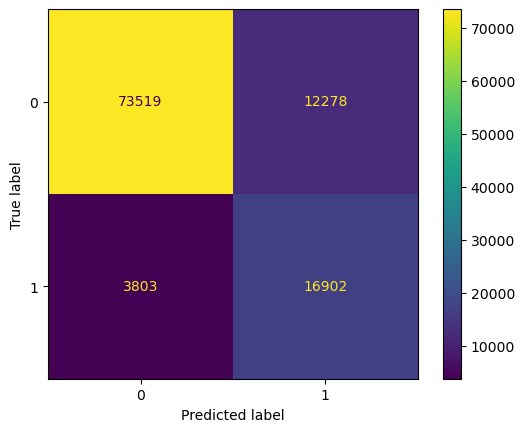

fbeta score : beta : 0.5
0.6149536110605786
              precision    recall  f1-score   support

           0       0.95      0.86      0.90     85797
           1       0.58      0.82      0.68     20705

    accuracy                           0.85    106502
   macro avg       0.77      0.84      0.79    106502
weighted avg       0.88      0.85      0.86    106502



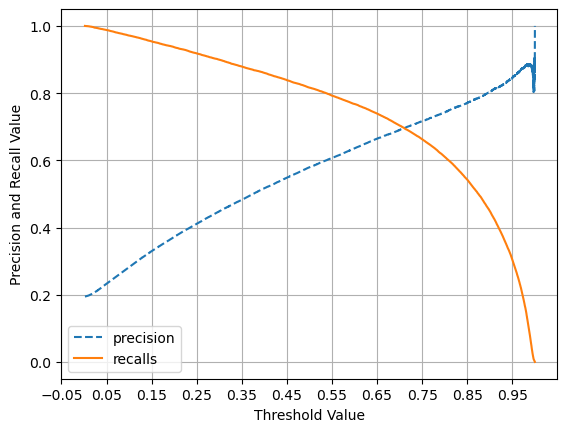

None
Precision at theshold 0.75 is :  0.7164116756305153



fbeta score : beta : 0.5 0.7049707632387548
              precision    recall  f1-score   support

           0       0.92      0.94      0.93     85797
           1       0.72      0.66      0.69     20705

    accuracy                           0.88    106502
   macro avg       0.82      0.80      0.81    106502
weighted avg       0.88      0.88      0.88    106502

Feature Importance : 


<Figure size 1500x800 with 0 Axes>

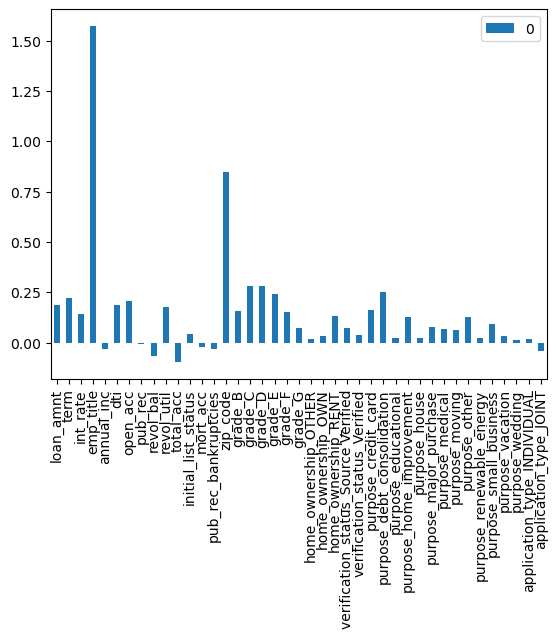

In [580]:
apply_logistic_regression(X_smote,y_smote)

LR train score: 0.8463671161417813
LR test score: 0.8490075303750164

Confusion Matrix: 
[[73519 12278]
 [ 3803 16902]]


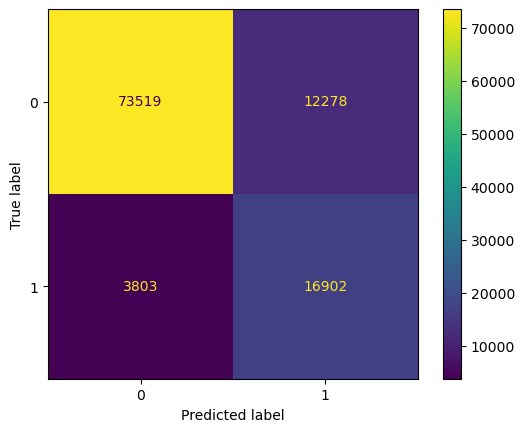

fbeta score : beta : 0.5
0.6149536110605786
              precision    recall  f1-score   support

           0       0.95      0.86      0.90     85797
           1       0.58      0.82      0.68     20705

    accuracy                           0.85    106502
   macro avg       0.77      0.84      0.79    106502
weighted avg       0.88      0.85      0.86    106502



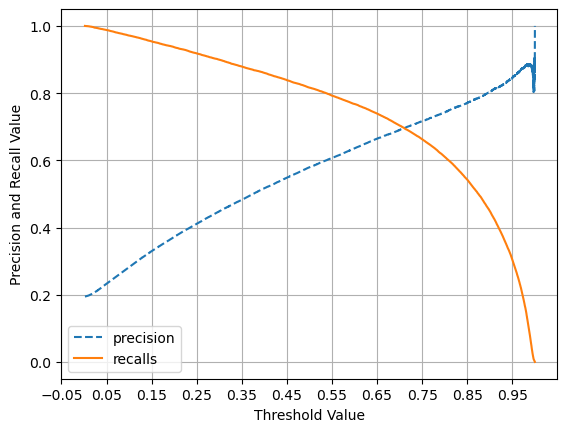

None
Precision at theshold 0.6 is :  0.6356328734253149



fbeta score : beta : 0.5 0.6582729343549388
              precision    recall  f1-score   support

           0       0.94      0.89      0.92     85797
           1       0.64      0.77      0.70     20705

    accuracy                           0.87    106502
   macro avg       0.79      0.83      0.81    106502
weighted avg       0.88      0.87      0.87    106502



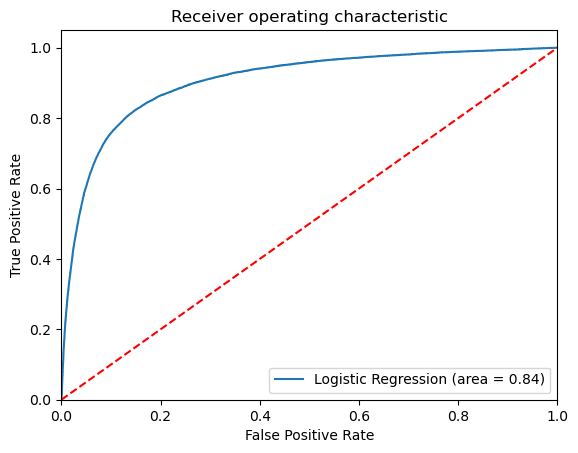

Feature Importance : 


<Figure size 1500x800 with 0 Axes>

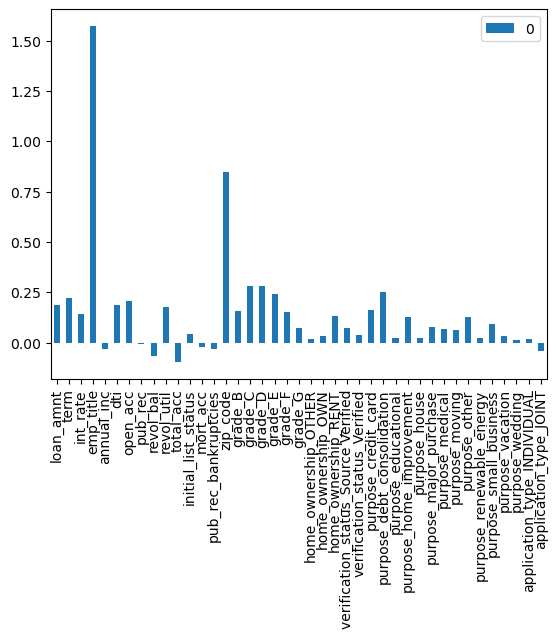

In [581]:

from sklearn.linear_model import LogisticRegression
logistic_reg_model = LogisticRegression(
    penalty='l2',         # L2 - ridge regularisation
    dual=False,
    tol=0.0001,
    C=1.0,             # 1/lambda : 
    fit_intercept=True,
    intercept_scaling=1,
    class_weight=None,
    random_state=None,
    solver='lbfgs',
    max_iter=1000,          # 1000 iterations for learning 
    multi_class='auto',
    verbose=0,
    warm_start=False,
    n_jobs=None,
    l1_ratio=None,)

logistic_reg_model.fit(X_smote,y_smote)
print("LR train score:",logistic_reg_model.score(X_smote,y_smote))
print("LR test score:",logistic_reg_model.score(X_test ,y_test))

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

y_predicted = logistic_reg_model.predict(X_test)

print()
print("Confusion Matrix: ")
print(confusion_matrix(y_test ,y_predicted ))

ConfusionMatrixDisplay(confusion_matrix(y_test ,y_predicted ),
                      display_labels=[0,1]).plot()

plt.show()

from sklearn.metrics import f1_score,precision_score,recall_score,fbeta_score
from sklearn.metrics import classification_report

print("fbeta score : beta : 0.5")
print(fbeta_score(y_true = y_test,
    y_pred = y_predicted,
    beta = 0.5))



print(classification_report(y_test, y_predicted))


from sklearn.metrics import roc_auc_score,roc_curve
from sklearn.metrics import precision_recall_curve

print(precision_recall_curve_plot(y_test, logistic_reg_model.predict_proba(X_test)[:,1]))
plt.show()



def custom_predict(X, threshold):
        probs = logistic_reg_model.predict_proba(X) 
        return (probs[:, 1] > threshold).astype(int)

# print(model.predict_proba(X_test))
threshold = 0.60

new_preds = custom_predict(X=X_test, threshold=threshold)


print(f"Precision at theshold {threshold} is : ",precision_score(y_test,new_preds))


print()
print()




print()
print("fbeta score : beta : 0.5",fbeta_score(y_true = y_test, y_pred = new_preds,
                                                beta = 0.5))
print(classification_report(y_test, new_preds))

logit_roc_auc = roc_auc_score(y_test, logistic_reg_model.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logistic_reg_model.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

print("Feature Importance : ")
plt.figure(figsize=(15,8))

pd.DataFrame(columns=X.columns,data= logistic_reg_model.coef_).T.plot(kind = "bar")
plt.show()

    

# DecisionTreeClassifier

In [582]:
from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier(criterion='gini',
                        splitter='best',
                        max_depth=14,
                        min_samples_split=2,
                        min_samples_leaf=1,
                        min_weight_fraction_leaf=0.0,
                        max_features=None,
                        random_state=None,
                        max_leaf_nodes=None,
                        min_impurity_decrease=0.0,
                        class_weight="balanced",
                        ccp_alpha=0.0,)

In [584]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
kfold = KFold(n_splits=5)
accuracy = np.mean(cross_val_score(model, X_smote, y_smote,
                                   cv=kfold, scoring='accuracy', n_jobs= -1))
print("Cross Validation accuracy: {:.3f}".format(accuracy))
model.fit(X_smote,y_smote)
print("test score:",model.score(X_test ,y_test))

Cross Validation accuracy: 0.934
test score: 0.9197385964582825


In [585]:
from sklearn.model_selection import GridSearchCV

In [586]:
from sklearn.tree import DecisionTreeClassifier
DTC = DecisionTreeClassifier
parameters  = {
    "max_depth" : [5,10,15],
    "min_samples_split" : [5,9],
    "min_samples_leaf" : [1,3,5]
}
GS_DTC = GridSearchCV(estimator = DTC(),param_grid=parameters
        )

In [587]:
GS_DTC.fit(X_smote,y_smote)

GridSearchCV(estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': [5, 10, 15],
                         'min_samples_leaf': [1, 3, 5],
                         'min_samples_split': [5, 9]})

In [588]:
GS_DTC.best_estimator_

DecisionTreeClassifier(max_depth=15, min_samples_split=5)

In [589]:
GS_DTC.best_score_

0.9298013772148848

In [148]:
# Final model , after hyper parameter tuning : 

train score: 0.9408639080940364
test score: 0.9197292069632496


Precision at theshold 0.75 is :  0.9159788099051374




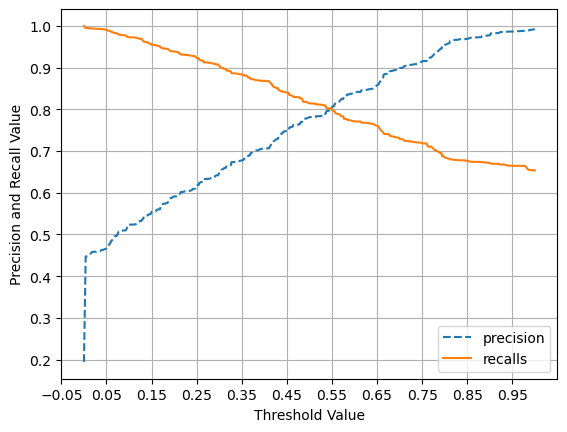

None

fbeta score : beta : 0.5 0.8681589425625577
              precision    recall  f1-score   support

           0       0.94      0.98      0.96     85797
           1       0.92      0.72      0.81     20705

    accuracy                           0.93    106502
   macro avg       0.93      0.85      0.88    106502
weighted avg       0.93      0.93      0.93    106502



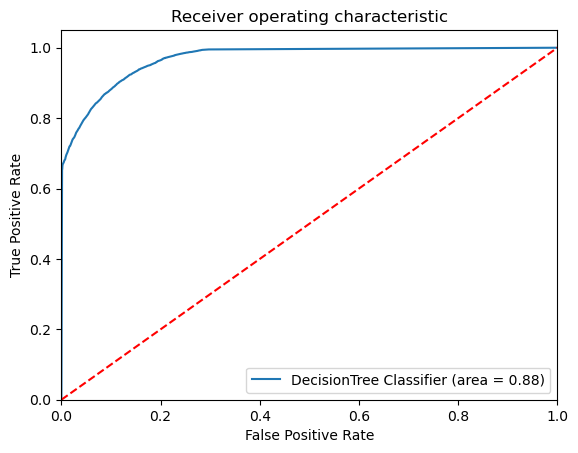

In [590]:
from sklearn.tree import DecisionTreeClassifier
DTmodel = DecisionTreeClassifier(criterion='gini',
                        splitter='best',
                        max_depth=14,
                        min_weight_fraction_leaf=0.0,
                        max_features=None,
                        random_state=None,
                        max_leaf_nodes=None,
                        min_impurity_decrease=0.0,
                        class_weight="balanced",
                        ccp_alpha=0.0,)
DTmodel.fit(X_smote,y_smote)
print("train score:",DTmodel.score(X_smote ,y_smote))
print("test score:",DTmodel.score(X_test ,y_test))
y_predicted = DTmodel.predict(X_test)

from sklearn.metrics import f1_score,precision_score,recall_score,fbeta_score
from sklearn.metrics import classification_report

print()
print()



def custom_predict(X, threshold):
        probs = DTmodel.predict_proba(X) 
        return (probs[:, 1] > threshold).astype(int)
    

threshold = 0.75

new_preds = custom_predict(X=X_test, threshold=threshold)


print(f"Precision at theshold {threshold} is : ",precision_score(y_test,new_preds))


print()
print()


print(precision_recall_curve_plot(y_test, DTmodel.predict_proba(X_test)[:,1]))
plt.show()

print()
print("fbeta score : beta : 0.5",fbeta_score(y_true = y_test, y_pred = new_preds,
                                                beta = 0.5))
print(classification_report(y_test, new_preds))

_roc_auc = roc_auc_score(y_test, DTmodel.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, DTmodel.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='DecisionTree Classifier (area = %0.2f)' % _roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('DecisionTreeClassifier_ROC')
plt.show()



## RandomForestClassifier

train score: 0.9925162144538853
test score: 0.9071942310942518




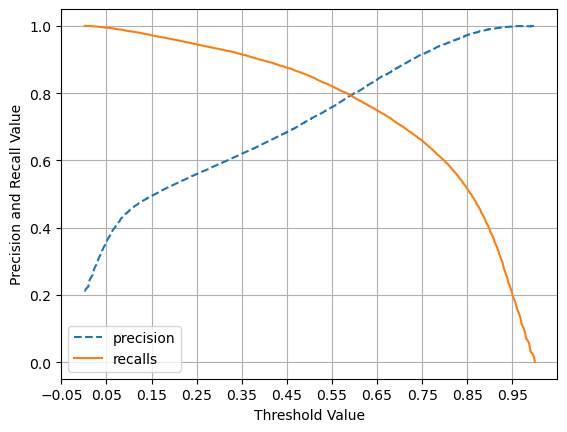

None
Precision at theshold 0.75 is :  0.9164313567298642



fbeta score : beta : 0.5 0.849802371541502
              precision    recall  f1-score   support

           0       0.92      0.99      0.95     85797
           1       0.92      0.66      0.77     20705

    accuracy                           0.92    106502
   macro avg       0.92      0.82      0.86    106502
weighted avg       0.92      0.92      0.92    106502

True
0.9413989975161896




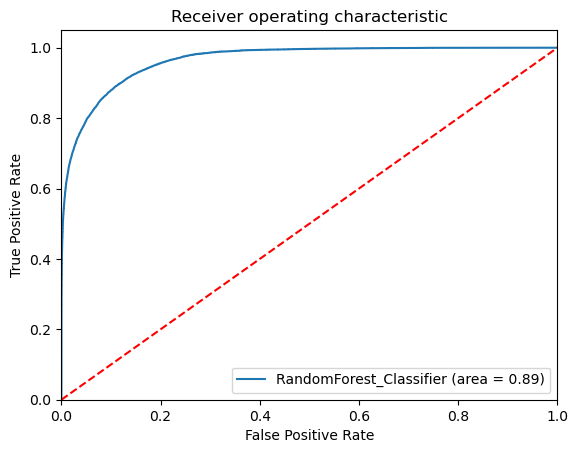

In [591]:
from sklearn.ensemble import RandomForestClassifier
RFmodel = RandomForestClassifier(
                                    n_estimators=100,
                                    criterion='gini',
                                    max_depth=25,
                                    min_samples_split=2,
                                    min_samples_leaf=1,
                                    min_weight_fraction_leaf=0.0,
                                    max_features='sqrt',
                                    max_leaf_nodes=None,
                                    min_impurity_decrease=0.0,
                                    bootstrap=True,
                                    oob_score=True,
                                    n_jobs=None,
                                    random_state=None,
                                    verbose=0,
                                    warm_start=False,
                                    class_weight=None,
                                    ccp_alpha=0.0,
                                    max_samples=None,
                                   )
RFmodel.fit(X_smote,y_smote)
print("train score:",RFmodel.score(X_smote ,y_smote))
print("test score:",RFmodel.score(X_test ,y_test))
y_predicted = RFmodel.predict(X_test)
from sklearn.metrics import f1_score,precision_score,recall_score,fbeta_score
from sklearn.metrics import classification_report

print()
print()


print(precision_recall_curve_plot(y_test, RFmodel.predict_proba(X_test)[:,1]))
plt.show()

def custom_predict(X, threshold):
        probs = RFmodel.predict_proba(X) 
        return (probs[:, 1] > threshold).astype(int)
    
# print(model.predict_proba(X_test))
threshold = 0.75

new_preds = custom_predict(X=X_test, threshold=threshold)


print(f"Precision at theshold {threshold} is : ",precision_score(y_test,new_preds))


print()
print()




print()
print("fbeta score : beta : 0.5",fbeta_score(y_true = y_test, y_pred = new_preds,
                                                beta = 0.5))
print(classification_report(y_test, new_preds))
print(RFmodel.oob_score)
print(RFmodel.oob_score_)



print()
print()



_roc_auc = roc_auc_score(y_test, RFmodel.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, RFmodel.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='RandomForest_Classifier (area = %0.2f)' % _roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('RandomForest_Classifier_ROC')
plt.show()



In [592]:
confusion_matrix(y_test, new_preds)

array([[84554,  1243],
       [ 7074, 13631]], dtype=int64)

In [593]:
precision_score(y_test, new_preds)

0.9164313567298642

## GradientBoostingClassifier

In [594]:
from sklearn.ensemble import GradientBoostingClassifier

train score: 0.9444004758562675
test score: 0.92487465024131


Precision at theshold 0.75 is :  0.9695362437100503




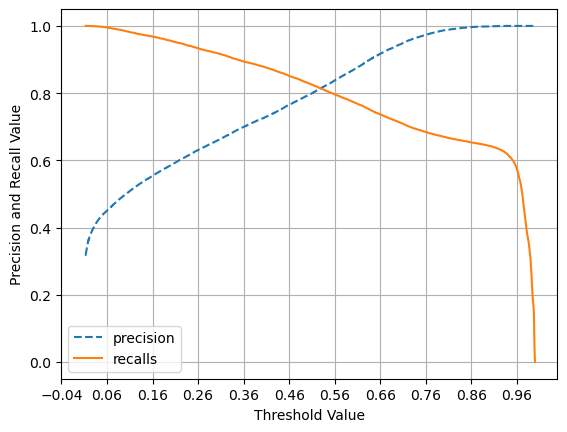

None

fbeta score : beta : 0.5 0.89640257013165
              precision    recall  f1-score   support

           0       0.93      0.99      0.96     85797
           1       0.97      0.69      0.81     20705

    accuracy                           0.94    106502
   macro avg       0.95      0.84      0.88    106502
weighted avg       0.94      0.94      0.93    106502



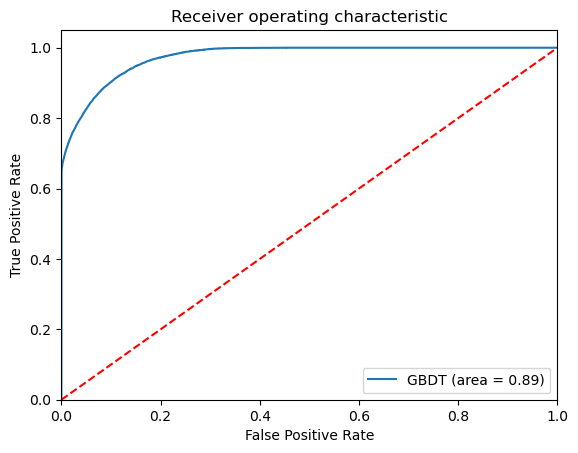

In [597]:
from sklearn.tree import DecisionTreeClassifier
GBDTmodel = GradientBoostingClassifier(
                                    loss='deviance',
                                    learning_rate=0.1,
                                    n_estimators=150,
                                    subsample=1.0,
                                    criterion='friedman_mse',
                                    min_samples_split=2,
                                    min_samples_leaf=1,
                                    min_weight_fraction_leaf=0.0,
                                    max_depth=3,
                                    min_impurity_decrease=0.0,
                                    init=None,
                                    random_state=None,
                                    max_features=None,
                                    verbose=0,
                                    max_leaf_nodes=None,
                                    warm_start=False,
                                    validation_fraction=0.1,
                                    n_iter_no_change=None,
                                    tol=0.0001,
                                    ccp_alpha=0.0
                                   )
GBDTmodel.fit(X_smote,y_smote)
print("train score:",GBDTmodel.score(X_smote ,y_smote))
print("test score:",GBDTmodel.score(X_test ,y_test))
y_predicted = GBDTmodel.predict(X_test)
from sklearn.metrics import f1_score,precision_score,recall_score,fbeta_score
from sklearn.metrics import classification_report

print()
print()



def custom_predict(X, threshold):
        probs = GBDTmodel.predict_proba(X) 
        return (probs[:, 1] > threshold).astype(int)
    
# print(model.predict_proba(X_test))
threshold = 0.75

new_preds = custom_predict(X=X_test, threshold=threshold)


print(f"Precision at theshold {threshold} is : ",precision_score(y_test,new_preds))


print()
print()

print(precision_recall_curve_plot(y_test, GBDTmodel.predict_proba(X_test)[:,1]))
plt.show()



print()
print("fbeta score : beta : 0.5",fbeta_score(y_true = y_test, y_pred = new_preds,
                                                beta = 0.5))
print(classification_report(y_test, new_preds))





_roc_auc = roc_auc_score(y_test, GBDTmodel.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, GBDTmodel.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='GBDT (area = %0.2f)' % _roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('GBDT_ROC')
plt.show()



In [598]:
confusion_matrix(y_test, new_preds)

array([[85349,   448],
       [ 6447, 14258]], dtype=int64)

In [156]:
 
#         0  1
#     0  TN  FP
#     1  FN  TP
    
#     TP/  FP + TP
    
#     TP / FN + TP

In [599]:
precision_score(y_test, new_preds)

0.9695362437100503

## XGBoost GBDT

In [600]:
from xgboost import XGBClassifier

In [601]:
xgbc = XGBClassifier(n_estimators = 70,max_depth =5)

train score: 0.9590644148112752
test score: 0.934724230530882


Precision at theshold 0.65 is :  0.9628947368421052




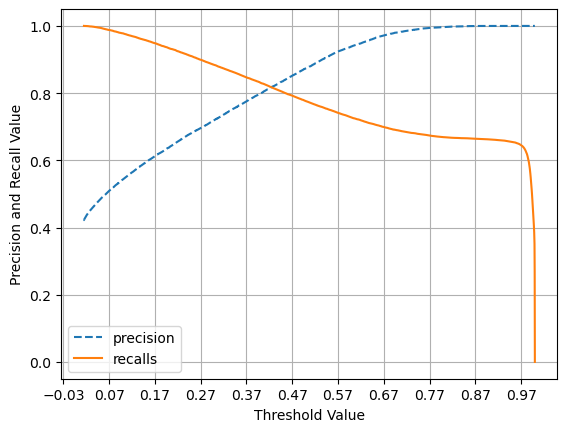

None

fbeta score : beta : 0.5 0.897859027053555
              precision    recall  f1-score   support

           0       0.93      0.99      0.96     85797
           1       0.96      0.71      0.82     20705

    accuracy                           0.94    106502
   macro avg       0.95      0.85      0.89    106502
weighted avg       0.94      0.94      0.93    106502



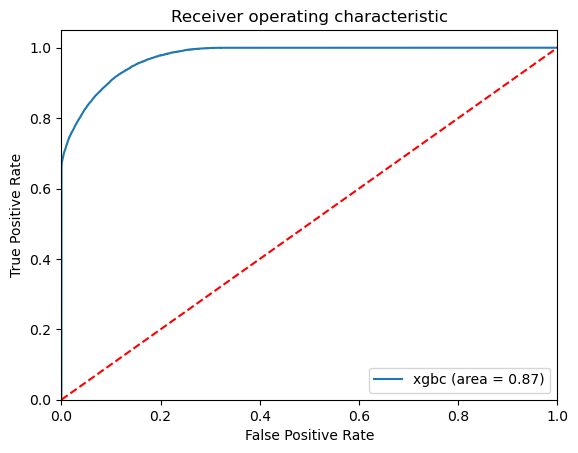

In [661]:
xgbc.fit(X_smote,y_smote)
print("train score:",xgbc.score(X_smote ,y_smote))
print("test score:",xgbc.score(X_test ,y_test))
y_predicted = xgbc.predict(X_test)
from sklearn.metrics import f1_score,precision_score,recall_score,fbeta_score
from sklearn.metrics import classification_report

print()
print()



def custom_predict(X, threshold):
        probs = xgbc.predict_proba(X) 
        return (probs[:, 1] > threshold).astype(int)
    
# print(model.predict_proba(X_test))
threshold = 0.65

new_preds = custom_predict(X=X_test, threshold=threshold)


print(f"Precision at theshold {threshold} is : ",precision_score(y_test,new_preds))


print()
print()

print(precision_recall_curve_plot(y_test, xgbc.predict_proba(X_test)[:,1]))
plt.show()



print()
print("fbeta score : beta : 0.5",fbeta_score(y_true = y_test, y_pred = new_preds,
                                                beta = 0.5))
print(classification_report(y_test, new_preds))





_roc_auc = roc_auc_score(y_test, xgbc.predict(X_test))
_roc_auc 
fpr, tpr, thresholds = roc_curve(y_test, xgbc.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='xgbc (area = %0.2f)' % _roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('XGB_ROC')
plt.show()


In [161]:
# confusion_matrix(y_test, new_preds)

#### Failed Attempt to apply KNeighborsClassifier :P 

In [162]:
# from sklearn.neighbors import KNeighborsClassifier

In [163]:
# kNN_model  = KNeighborsClassifier(n_neighbors=9)

In [164]:
# kNN_model.fit(X_smote,y_smote)
# print("train score:",kNN_model.score(X_train ,y_train))
# print("test score:",kNN_model.score(X_test ,y_test))
# y_predicted = kNN_model.predict(X_test)
# from sklearn.metrics import f1_score,precision_score,recall_score,fbeta_score
# from sklearn.metrics import classification_report

# print()
# print()



# def custom_predict(X, threshold):
#         probs = kNN_model.predict_proba(X) 
#         return (probs[:, 1] > threshold).astype(int)
    
# # print(model.predict_proba(X_test))
# threshold = 0.75

# new_preds = custom_predict(X=X_test, threshold=threshold)


# print(f"Precision at theshold {threshold} is : ",precision_score(y_test,new_preds))


# print()
# print()

# print(precision_recall_curve_plot(y_test, kNN_model.predict_proba(X_test)[:,1]))
# plt.show()



# print()
# print("fbeta score : beta : 0.5",fbeta_score(y_true = y_test, y_pred = new_preds,
#                                                 beta = 0.5))
# print(classification_report(y_test, new_preds))





# _roc_auc = roc_auc_score(y_test, kNN_model.predict(X_test))
# fpr, tpr, thresholds = roc_curve(y_test, kNN_model.predict_proba(X_test)[:,1])
# plt.figure()
# plt.plot(fpr, tpr, label='kNN Classifier(area = %0.2f)' % _roc_auc)
# plt.plot([0, 1], [0, 1],'r--')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver operating characteristic')
# plt.legend(loc="lower right")
# plt.savefig('Log_ROC')
# plt.show()


#### Feature Importance according to Random Forest Model :

In [ ]:
plt.figure(figsize=(8,12))
sns.barplot(x = pd.DataFrame(index=X.columns,data= RFmodel.feature_importances_)[0],
           y =pd.DataFrame(index=X.columns,data= RFmodel.feature_importances_).index)

#### Feature Importance according to Logitistc Regression Model :

In [ ]:
plt.figure(figsize=(8,12))
sns.barplot(x = pd.DataFrame(columns=X.columns,data= logistic_reg_model.coef_).T[0],
           y =pd.DataFrame(columns=X.columns,data= logistic_reg_model.coef_).T.index)

#### Feature Importance according to XGBoost Classifier Model :

In [ ]:
plt.figure(figsize=(8,12))
sns.barplot(x = pd.DataFrame(index=X.columns,data= xgbc.feature_importances_)[0],
           y =pd.DataFrame(index=X.columns,data= xgbc.feature_importances_).index)

In [614]:
X_smote

array([[-1.2207546 , -0.56096757,  1.0516416 , ..., 14.36170424,
         0.03056898, -0.02729492],
       [ 2.37781537,  1.78263425,  1.21925744, ..., -0.06962962,
         0.03056898, -0.02729492],
       [ 0.05220893, -0.56096757, -0.78307225, ..., -0.06962962,
         0.03056898, -0.02729492],
       ...,
       [-1.00099335,  1.78263425, -0.09098725, ..., -0.06962962,
         0.03056898, -0.02729492],
       [-0.02349167, -0.56096757,  0.9034821 , ..., -0.06962962,
         0.03056898, -0.02729492],
       [-1.13549327, -0.56096757, -0.2530438 , ..., -0.06962962,
         0.03056898, -0.02729492]])

## Final stacking models

Logistic regression

In [722]:
train_model_predictions = pd.DataFrame({'xgb_prediction':xgbc.predict_proba(X_smote)[:, 1],
'gb_prediction':GBDTmodel.predict_proba(X_smote)[:, 1],
'rf_prediction':RFmodel.predict_proba(X_smote)[:, 1],
'dt_prediction':DTmodel.predict_proba(X_smote)[:, 1],
'lr_prediction':logistic_reg_model.predict_proba(X_smote)[:, 1]})

In [723]:
test_model_predictions = pd.DataFrame({'xgb_prediction':xgbc.predict_proba(X_test)[:, 1],
'gb_prediction':GBDTmodel.predict_proba(X_test)[:, 1],
'rf_prediction':RFmodel.predict_proba(X_test)[:, 1],
'dt_prediction':DTmodel.predict_proba(X_test)[:, 1],
'lr_prediction':logistic_reg_model.predict_proba(X_test)[:, 1]})

In [726]:
from sklearn.linear_model import LogisticRegression
final_lr_model = LogisticRegression(
    penalty='elasticnet',         # L2 - ridge regularisation
    dual=False,
    tol=0.0001,
    fit_intercept=True,
    C = {best_c},
    intercept_scaling=1,
    class_weight=None,
    random_state=None,
    solver='saga',
    max_iter=10000,          # 1000 iterations for learning 
    multi_class='auto',
    verbose=0,
    warm_start=False,
    n_jobs=None,
    l1_ratio=0.5,)


params = {
    'C': np.logspace(-4, 4, 20)  # You can modify the range and the number of values as needed
}

# Create the GridSearchCV object
grid_search = GridSearchCV(final_lr_model, params, cv=5, scoring='roc_auc', verbose=1, n_jobs=-1)

# Fit the model using grid search
grid_search.fit(train_model_predictions, y_smote)

# Get the best C-value
best_c = grid_search.best_params_['C']
print(f"Best C-value: {best_c}")

# Get the best logistic regression model


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best C-value: 545.5594781168514


In [740]:

import numpy as np
from sklearn.metrics import precision_recall_curve, f1_score

best_final_logistic_regression = grid_search.best_estimator_

# Replace 'y_test' with the true labels of your test set
accuracy = best_final_logistic_regression.score(train_model_predictions, y_smote)
print(f"Train Accuracy: {accuracy}")
accuracy2 = best_final_logistic_regression.score(test_model_predictions, y_test)
print(f"Test Accuracy: {accuracy2}")

y_pred_prob = best_final_logistic_regression.predict_proba(train_model_predictions)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_smote, y_pred_prob)
f1_scores = 2 * (precision * recall) / (precision + recall)
best_threshold = thresholds[np.argmax(f1_scores)]
print("Best probability threshold:", best_threshold)

def custom_predict(model, X, threshold):
    probs = model.predict_proba(X)
    return (probs[:, 1] > threshold).astype(int)

stack_lr_train_pred = custom_predict(best_final_logistic_regression, train_model_predictions, best_threshold)
stack_lr_test_pred = custom_predict(best_final_logistic_regression, test_model_predictions, best_threshold)

Train Accuracy: 0.999161278440625
Test Accuracy: 0.9187245309947231
Best probability threshold: 0.4526551888724012


In [745]:
print(f"Precision at theshold {best_threshold} is : ",precision_score(y_smote, stack_lr_train_pred))
print(f"Precision at theshold {best_threshold} is : ",precision_score(y_test, stack_lr_test_pred))

Precision at theshold 0.4526551888724012 is :  0.9989551563036415
Precision at theshold 0.4526551888724012 is :  0.8264996203492787


Precision at theshold 0.4526551888724012 is :  0.8264996203492787




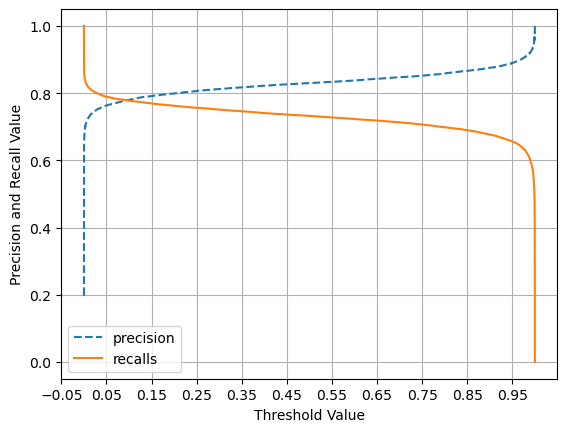

None

fbeta score : beta : 0.5 0.8066633494606011
              precision    recall  f1-score   support

           0       0.94      0.96      0.95     85797
           1       0.83      0.74      0.78     20705

    accuracy                           0.92    106502
   macro avg       0.88      0.85      0.86    106502
weighted avg       0.92      0.92      0.92    106502

0.8479284994608715


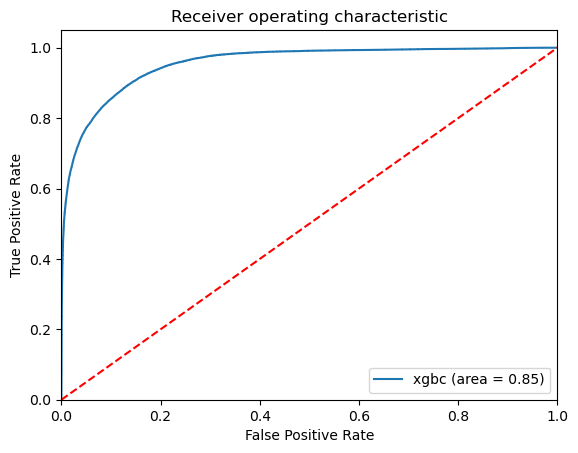

In [743]:

def custom_predict(model, X, threshold):
    probs = model.predict_proba(X)
    return (probs[:, 1] > threshold).astype(int)

# print(model.predict_proba(X_test))


new_preds = custom_predict(model = best_final_logistic_regression, X=test_model_predictions, threshold=best_threshold)


print(f"Precision at theshold {best_threshold} is : ",precision_score(y_test,new_preds))


print()
print()

print(precision_recall_curve_plot(y_test, best_final_logistic_regression.predict_proba(test_model_predictions)[:,1]))
plt.show()



print()
print("fbeta score : beta : 0.5",fbeta_score(y_true = y_test, y_pred = new_preds,
                                                beta = 0.5))
print(classification_report(y_test, new_preds))





_roc_auc = roc_auc_score(y_test, best_final_logistic_regression.predict(test_model_predictions))
print(_roc_auc )
fpr, tpr, thresholds = roc_curve(y_test, best_final_logistic_regression.predict_proba(test_model_predictions)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='xgbc (area = %0.2f)' % _roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('XGB_ROC')
plt.show()

## Decision Tree Classifier

In [727]:
from sklearn.model_selection import RandomizedSearchCV
final_lr_model = DecisionTreeClassifier()

param_dist = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None] + list(np.arange(1, 11)),
    'min_samples_split': np.arange(2, 21),
    'min_samples_leaf': np.arange(1, 21),
}

random_search = RandomizedSearchCV(final_lr_model, param_distributions=param_dist, n_iter=100, cv=5, n_jobs=-1, random_state=42)

# Fit the model using random search
random_search.fit(train_model_predictions, y_smote)

# Print the best parameters
print("Best parameters found:")
print(random_search.best_params_)

# Get the best Decision Tree Classifier
best_dtc = random_search.best_estimator_

best_final_dtr_regression = random_search.best_estimator_

In [747]:
import numpy as np
from sklearn.metrics import precision_recall_curve, f1_score

best_final_dtr_regression = random_search.best_estimator_

# Replace 'y_test' with the true labels of your test set
accuracy = best_final_dtr_regression.score(train_model_predictions, y_smote)
print(f"Train Accuracy: {accuracy}")
accuracy2 = best_final_dtr_regression.score(test_model_predictions, y_test)
print(f"Test Accuracy: {accuracy2}")

y_pred_prob = best_final_dtr_regression.predict_proba(train_model_predictions)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_smote, y_pred_prob)
f1_scores = 2 * (precision * recall) / (precision + recall)
best_threshold = thresholds[np.argmax(f1_scores)]
print("Best probability threshold:", best_threshold)

def custom_predict(model, X, threshold):
    probs = model.predict_proba(X)
    return (probs[:, 1] > threshold).astype(int)

stack_dtr_train_pred = custom_predict(best_final_dtr_regression, train_model_predictions, best_threshold)
stack_dtr_test_pred = custom_predict(best_final_dtr_regression, test_model_predictions, best_threshold)

Train Accuracy: 0.9998506727193991
Test Accuracy: 0.922912245779422
Best probability threshold: 0.5


In [749]:
print(f"Precision at theshold {best_threshold} is : ",precision_score(y_smote, stack_dtr_train_pred))
print(f"Precision at theshold {best_threshold} is : ",precision_score(y_test, stack_dtr_test_pred))

Precision at theshold 0.5 is :  0.9998755544051252
Precision at theshold 0.5 is :  0.8354722654781721


Precision at theshold 0.5 is :  0.8354722654781721




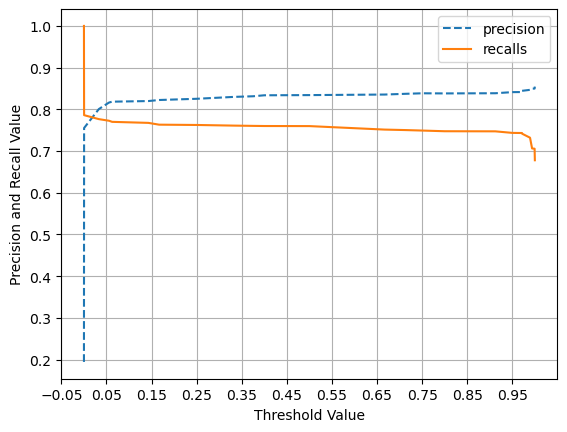

None

fbeta score : beta : 0.5 0.8172001218525794
              precision    recall  f1-score   support

           0       0.94      0.96      0.95     85797
           1       0.84      0.75      0.79     20705

    accuracy                           0.92    106502
   macro avg       0.89      0.86      0.87    106502
weighted avg       0.92      0.92      0.92    106502

0.8578743976845408


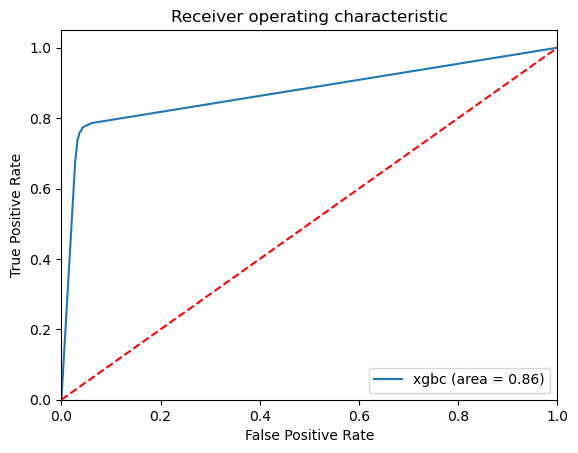

In [750]:

def custom_predict(model, X, threshold):
    probs = model.predict_proba(X)
    return (probs[:, 1] > threshold).astype(int)

# print(model.predict_proba(X_test))


new_preds = custom_predict(model = best_final_dtr_regression, X=test_model_predictions, threshold=best_threshold)


print(f"Precision at theshold {best_threshold} is : ",precision_score(y_test,new_preds))


print()
print()

print(precision_recall_curve_plot(y_test, best_final_dtr_regression.predict_proba(test_model_predictions)[:,1]))
plt.show()



print()
print("fbeta score : beta : 0.5",fbeta_score(y_true = y_test, y_pred = new_preds,
                                                beta = 0.5))
print(classification_report(y_test, new_preds))





_roc_auc = roc_auc_score(y_test, best_final_dtr_regression.predict(test_model_predictions))
print(_roc_auc )
fpr, tpr, thresholds = roc_curve(y_test, best_final_dtr_regression.predict_proba(test_model_predictions)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='xgbc (area = %0.2f)' % _roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('XGB_ROC')
plt.show()

## Mean of predictions

In [751]:
another_train_model = train_model_predictions.copy()

In [752]:
another_test_model = test_model_predictions.copy()

In [753]:
final_train_predictions = another_train_model.mean(axis=1)
final_test_predictions = another_test_model.mean(axis=1)


In [754]:
y_pred_prob = final_train_predictions
precision, recall, thresholds = precision_recall_curve(y_smote, y_pred_prob)
f1_scores = 2 * (precision * recall) / (precision + recall)
best_threshold = thresholds[np.argmax(f1_scores)]
print("Best probability threshold:", best_threshold)


Best probability threshold: 0.5366846262375743


In [755]:
def custom_predict(X, best_threshold):
    return (X > threshold).astype(int)

final_train_classifications = custom_predict(final_train_predictions, best_threshold)
final_test_classifications = custom_predict(final_test_predictions, best_threshold)

In [756]:
accuracy = accuracy_score(y_smote, final_train_classifications)
print(f"Accuracy: {accuracy}")
accuracy2 = accuracy_score(y_test, final_test_classifications)
print(f"Accuracy: {accuracy2}")

Accuracy: 0.9561326225354777
Accuracy: 0.935174926292464


Precision at theshold 0.5366846262375743 is :  0.8930788949017374




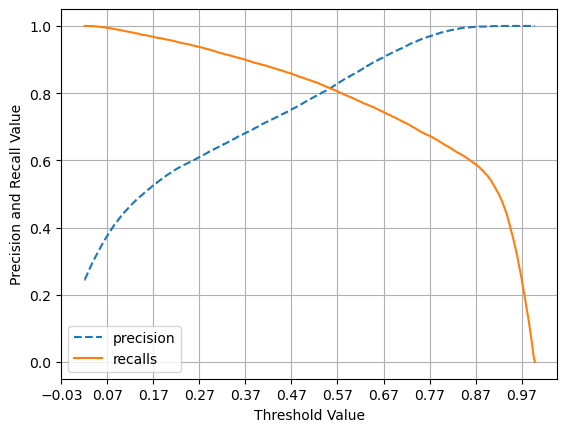

None

fbeta score : beta : 0.5 0.8621391256530108
              precision    recall  f1-score   support

           0       0.94      0.98      0.96     85797
           1       0.89      0.76      0.82     20705

    accuracy                           0.94    106502
   macro avg       0.92      0.87      0.89    106502
weighted avg       0.93      0.94      0.93    106502

0.8676655909764617


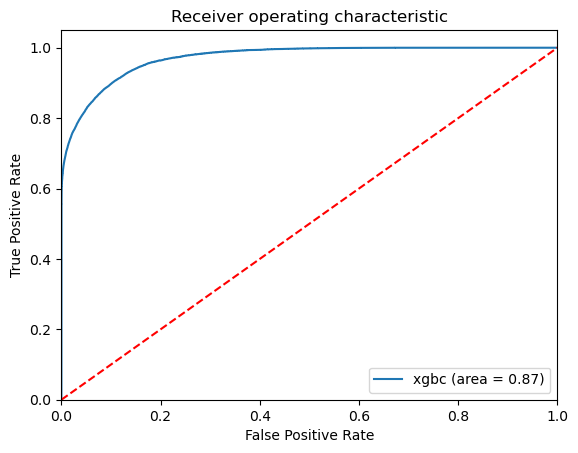

In [757]:
new_preds = final_test_classifications

print(f"Precision at theshold {best_threshold} is : ",precision_score(y_test,final_test_classifications))


print()
print()

print(precision_recall_curve_plot(y_test, final_test_predictions))
plt.show()



print()
print("fbeta score : beta : 0.5",fbeta_score(y_true = y_test, y_pred = new_preds,
                                                beta = 0.5))
print(classification_report(y_test, new_preds))


_roc_auc = roc_auc_score(y_test, final_test_classifications)
print(_roc_auc )
fpr, tpr, thresholds = roc_curve(y_test, final_test_predictions)
plt.figure()
plt.plot(fpr, tpr, label='xgbc (area = %0.2f)' % _roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('XGB_ROC')
plt.show()

## Data Analysis report : 

- Interest Rate Mean and Median , Loan Amount distribution / median of Loan amount is higher for Borrowers who are more likely to be defaulter.
- Borrowers having Loan Grades E ,F, G , have more probability of default.
- G grade has the highest conditional probability of having defaulter.
- Employement Length has overall same probability of Loan_status as fully paid and defaulter. That means Defaulters has no relation with their Emoployement length.


- For those borrowers who have rental home, has higher probability of defaulters. borrowers having their home mortgage and owns have lower probability of defaulter.


- Annual income median is lightly higher for those who's loan status is as fully paid.


- Most of the borrowers take loans for dept-consolidation and credit card payoffs. Probability of defaulters is higher in the small_business owner borrowers.


- debt-to-income ratio is higher for defaulters.


- Number of derogatory public records increases , the probability of borrowers declared as defaulters also increases


- Application type Direct-Pay has higher probability of defaulter borrowers than individual and joint.





# Report : Insights and Model Results : 

## 

- Since  , NBFCs are willing to take risk giving loans to borrowers having low credit grades (who have high probability of default) , as far as they do not have bankruptcy record present in credit repost , copany can affort to give loans, and maximise their earning by receiving high interest from such borrowers. 

- so this reason , we have done feature engineering steps such as ,
    - borrowers having more than 0 public records , mortgage accounts or public recorded bankruptcy present in report, have converted those feature values to 1 (means they are more likely to become a defaulter).
        

- Our goal in Model building was to 
    - minimise , below metrics : 
        - incorrectly classified as defaulter : FP  
        - incorretly classified  as non-defaulter :  FN   
        
        <> Minimise the False Positive, 
        - means we dont want to say defaulter to a borrower who is not really a deaulter. that means we will lose the opportunity  (minimise False Positive) (Dont loose opportunity )
        
        <> Minimise the False Negatives:
        - Means we dont want to declare a borrower a non-defaulter, who is actually more likely to become a defaulter. Thats a risk on company giving loans to such borrower. 
        - But since, as NBFCs are willing to take risk , we can be a little liberal about this point.
        
        Hence the Precision is more important metric 
        SO we have focused on Maximising Precision metric and also F0.5 score. 
        
        
        


# LogisitcRegression 
    
    
        1 : (when imbalanced data)
        
            Model Accuracy on Training Data :    0.8512170879224799
            Model Accuracy on Test Data     :    0.8486319505736981

            fbeta_score(beta = 0.5)         :    0.6021737454713635
       
            Model Report : 
            
        
                                 precision    recall  f1-score   support

                       0       0.86      0.96      0.91     85797
                       1       0.71      0.38      0.49     20705

                accuracy                           0.85    106502
               macro avg       0.79      0.67      0.70    106502
            weighted avg       0.83      0.85      0.83    106502
        
        
        
        2 :  after Balancing Data using SMOTE - :
            
            Model Accuracy on Training Data :     0.7491127470744297
            Model Accuracy on Test Data     :     0.7532440705338866

            Precision at theshold 0.75 is :  0.9333046933734293



            fbeta score : (beta =0.5) :  0.7497972355001812
            
            Model Report :
                          precision    recall  f1-score   support

                       0       0.88      0.99      0.93     85797
                       1       0.93      0.42      0.58     20705

                accuracy                           0.88    106502
               macro avg       0.90      0.71      0.75    106502
            weighted avg       0.89      0.88      0.86    106502



# Decision Tree

        Cross Validation accuracy: 0.896
        Model Accuracy on Test Data : 0.8804529492403899

        Model Accuracy on Training Data : 0.8898765809668294
        Model Accuracy on Test Data : 0.8805468441907194


        Precision at theshold 0.75 is :  0.9353794952389757



        fbeta score :(beta =0.5) :   0.7908023697497382


        Model Report: 
                      precision    recall  f1-score   support

                   0       0.89      0.99      0.94     85797
                   1       0.94      0.49      0.64     20705

            accuracy                           0.89    106502
           macro avg       0.91      0.74      0.79    106502
        weighted avg       0.90      0.89      0.88    106502






# RandomForest



        Model Accuracy on Training Data : 0.9759479764831813
        Model Accuracy on Test Data     : 0.8653828097124937


        Precision at theshold 0.75 is   :  0.9333046933734293
        oob_score_ : 0.914208988506777
        

        fbeta score : (beta=0.5)        :  0.7497972355001812
        
        
        
                      precision    recall  f1-score   support

                   0       0.88      0.99      0.93     85797
                   1       0.93      0.42      0.58     20705

            accuracy                           0.88    106502
           macro avg       0.90      0.71      0.75    106502
        weighted avg       0.89      0.88      0.86    106502


        


# GradientBoostingClassifier

        Model Accuracy on Training Data : 0.8809994245542307
        Model Accuracy on Test Data     : 0.8792980413513362


        Precision at theshold 0.75 is   :  0.9896128423040604



        fbeta score : (beta=0.5)        : 0.8016454469734315
        
        
                      precision    recall  f1-score   support

                   0       0.88      1.00      0.94     85797
                   1       0.99      0.46      0.62     20705

            accuracy                           0.89    106502
           macro avg       0.94      0.73      0.78    106502
        weighted avg       0.90      0.89      0.88    106502





